# Évaluation des modèles pour la détection de pneumonie

Ce notebook présente l'évaluation des différents modèles entraînés pour la détection de pneumonie à partir d'images radiographiques.

In [1]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pour la gestion de la mémoire
import gc

# Pour éviter les avertissements
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

# Vérifier la disponibilité du GPU
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU disponible: {gpus}")
    # Limiter l'utilisation de la mémoire GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Croissance dynamique de la mémoire GPU activée")
    except RuntimeError as e:
        print(f"Erreur lors de la configuration de la mémoire GPU: {e}")
else:
    print("Aucun GPU détecté, utilisation du CPU")

TensorFlow version: 2.13.0
Aucun GPU détecté, utilisation du CPU


## 1. Chargement des données de test

Nous allons d'abord charger les données de test pour évaluer les modèles.

Chargement des images...
Contenu du répertoire C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\data:
['test', 'train', 'val']
Structure train/test détectée. Chargement des images du dossier 'test'...
Chargement des images de la classe 'NORMAL' (label: 0)...
  50 images chargées...
  100 images chargées...
  150 images chargées...
  200 images chargées...
  Total: 234 images chargées pour la classe 'NORMAL'
Chargement des images de la classe 'PNEUMONIA' (label: 1)...
  50 images chargées...
  100 images chargées...
  150 images chargées...
  200 images chargées...
  250 images chargées...
  300 images chargées...
  350 images chargées...
  Total: 390 images chargées pour la classe 'PNEUMONIA'

Nombre total d'images chargées: 624
  - Classe 'Normal': 234 images (37.5%)
  - Classe 'Pneumonie': 390 images (62.5%)

Préparation des données pour l'évaluation...
Normalisation des images...
Données préparées: 499 images d'entraînement, 125 images 

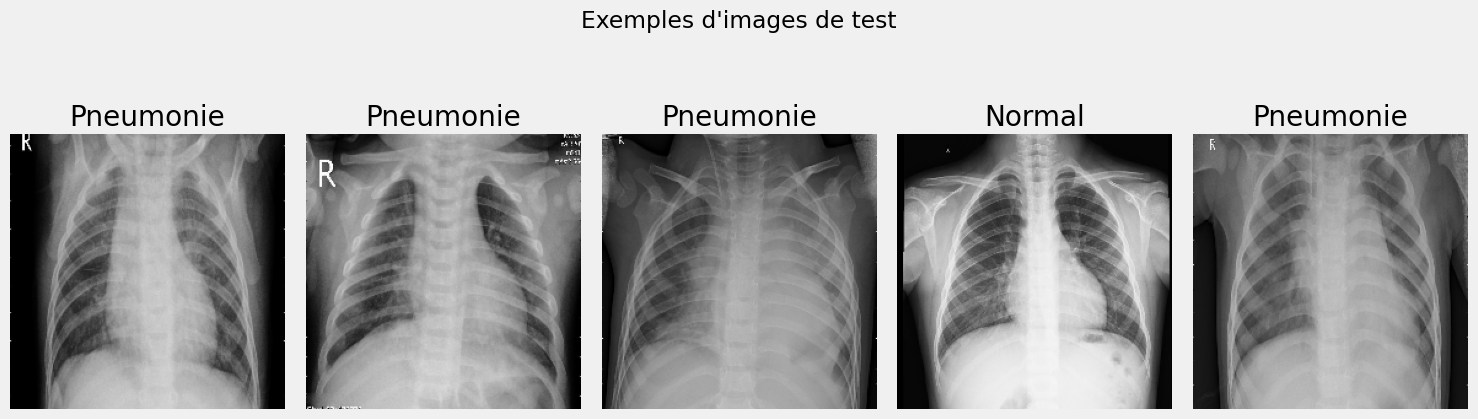

In [2]:
# Définir le chemin vers les données
# Remplacez ce chemin par le chemin réel vers vos données
data_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\data'

# Fonction pour charger les images
def load_images_from_dir(directory, img_size=(224, 224), max_images=None):
    """
    Charge les images d'un répertoire avec leurs étiquettes.
    
    Args:
        directory (str): Chemin vers le répertoire contenant les images
        img_size (tuple): Taille des images après redimensionnement
        max_images (int): Nombre maximum d'images à charger par classe
        
    Returns:
        tuple: Images, étiquettes et noms de fichiers
    """
    images = []
    labels = []
    filenames = []
    
    # Vérifier si le répertoire existe
    if not os.path.exists(directory):
        print(f"Le répertoire {directory} n'existe pas.")
        return np.array([]), np.array([], dtype=int), []
    
    # Vérifier la structure du répertoire
    print(f"Contenu du répertoire {directory}:")
    dir_contents = os.listdir(directory)
    print(dir_contents)
    
    # Déterminer si nous avons une structure train/test ou directement des classes
    has_train_test = 'train' in dir_contents and 'test' in dir_contents
    
    if has_train_test:
        # Si nous avons une structure train/test, nous utilisons seulement le dossier test
        print("Structure train/test détectée. Chargement des images du dossier 'test'...")
        test_dir = os.path.join(directory, 'test')
        if not os.path.exists(test_dir):
            print(f"Le répertoire {test_dir} n'existe pas.")
            return np.array([]), np.array([], dtype=int), []
        
        # Parcourir les sous-répertoires (classes) dans le dossier test
        for class_name in os.listdir(test_dir):
            class_dir = os.path.join(test_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            # Déterminer l'étiquette (0 pour normal, 1 pour pneumonie)
            label = 0 if class_name.lower() == 'normal' else 1
            
            print(f"Chargement des images de la classe '{class_name}' (label: {label})...")
            
            # Parcourir les images dans le sous-répertoire
            img_count = 0
            for img_name in os.listdir(class_dir):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                    
                if max_images is not None and img_count >= max_images:
                    break
                    
                img_path = os.path.join(class_dir, img_name)
                
                # Charger et prétraiter l'image
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Impossible de charger l'image {img_path}")
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB
                    img = cv2.resize(img, img_size)  # Redimensionner
                    
                    images.append(img)
                    labels.append(label)
                    filenames.append(img_path)
                    img_count += 1
                    
                    # Afficher la progression
                    if img_count % 50 == 0:
                        print(f"  {img_count} images chargées...")
                except Exception as e:
                    print(f"Erreur lors du chargement de l'image {img_path}: {e}")
            
            print(f"  Total: {img_count} images chargées pour la classe '{class_name}'")
    else:
        # Si nous avons directement les classes, nous les utilisons toutes
        print("Structure avec classes directes détectée. Chargement de toutes les classes...")
        
        # Parcourir les sous-répertoires (classes)
        for class_name in dir_contents:
            class_dir = os.path.join(directory, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            # Déterminer l'étiquette (0 pour normal, 1 pour pneumonie)
            label = 0 if class_name.lower() == 'normal' else 1
            
            print(f"Chargement des images de la classe '{class_name}' (label: {label})...")
            
            # Parcourir les images dans le sous-répertoire
            img_count = 0
            for img_name in os.listdir(class_dir):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                    
                if max_images is not None and img_count >= max_images:
                    break
                    
                img_path = os.path.join(class_dir, img_name)
                
                # Charger et prétraiter l'image
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Impossible de charger l'image {img_path}")
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB
                    img = cv2.resize(img, img_size)  # Redimensionner
                    
                    images.append(img)
                    labels.append(label)
                    filenames.append(img_path)
                    img_count += 1
                    
                    # Afficher la progression
                    if img_count % 50 == 0:
                        print(f"  {img_count} images chargées...")
                except Exception as e:
                    print(f"Erreur lors du chargement de l'image {img_path}: {e}")
            
            print(f"  Total: {img_count} images chargées pour la classe '{class_name}'")
    
    # Convertir en tableaux NumPy
    images_array = np.array(images)
    labels_array = np.array(labels, dtype=int)  # Assurer que les labels sont des entiers
    
    return images_array, labels_array, filenames

# Charger les images
print("Chargement des images...")
images, labels, filenames = load_images_from_dir(data_dir)

# Afficher le nombre d'images chargées
if len(images) > 0:
    print(f"\nNombre total d'images chargées: {len(images)}")
    unique_labels, counts = np.unique(labels, return_counts=True)
    class_names = ['Normal', 'Pneumonie']
    for i, label in enumerate(unique_labels):
        print(f"  - Classe '{class_names[label]}': {counts[i]} images ({counts[i]/len(labels)*100:.1f}%)")
else:
    print("Aucune image n'a été chargée. Vérifiez le chemin du répertoire et la structure des données.")

# Préparer les données pour l'évaluation
def prepare_data_for_evaluation(images, labels, test_size=0.2):
    """
    Prépare les données pour l'évaluation en les divisant en ensembles d'entraînement et de test.
    
    Args:
        images (numpy.ndarray): Images à préparer
        labels (numpy.ndarray): Étiquettes des images
        test_size (float): Proportion des données pour le test
        
    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    if len(images) == 0:
        print("Aucune image à préparer.")
        return None, None, None, None
    
    # Normaliser les images
    print("Normalisation des images...")
    normalized_images = images / 255.0
    
    # Vérifier si nous avons besoin de diviser les données
    # Si nous avons déjà chargé uniquement les données de test, nous n'avons pas besoin de les diviser
    if 'test' in data_dir:
        print("Données de test déjà sélectionnées, pas besoin de division.")
        return None, normalized_images, None, labels
    
    # Diviser en ensembles d'entraînement et de test
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        normalized_images, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    print(f"Données préparées: {len(X_train)} images d'entraînement, {len(X_test)} images de test")
    
    # Afficher la distribution des classes dans chaque ensemble
    print("\nDistribution des classes:")
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    
    class_names = ['Normal', 'Pneumonie']
    print("Entraînement:")
    for i, label in enumerate(unique_train):
        print(f"  - Classe '{class_names[label]}': {counts_train[i]} images ({counts_train[i]/len(y_train)*100:.1f}%)")
    
    print("Test:")
    for i, label in enumerate(unique_test):
        print(f"  - Classe '{class_names[label]}': {counts_test[i]} images ({counts_test[i]/len(y_test)*100:.1f}%)")
    
    return X_train, X_test, y_train, y_test

# Préparer les données
print("\nPréparation des données pour l'évaluation...")
_, X_test, _, y_test = prepare_data_for_evaluation(images, labels)

# Vérifier si les données de test sont disponibles
if X_test is not None and len(X_test) > 0:
    print(f"\nDonnées de test prêtes: {len(X_test)} images")
    print(f"Forme des images: {X_test.shape}")
    print(f"Plage de valeurs: [{X_test.min():.1f}, {X_test.max():.1f}]")
    
    # Visualiser quelques exemples
    plt.figure(figsize=(15, 5))
    class_names = ['Normal', 'Pneumonie']
    
    for i in range(5):
        if i < len(X_test):
            plt.subplot(1, 5, i+1)
            plt.imshow(X_test[i])
            plt.title(f"{class_names[y_test[i]]}")
            plt.axis('off')
    
    plt.suptitle("Exemples d'images de test")
    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée de test disponible. Vérifiez le chargement des données.")

## 2. Chargement des modèles entraînés

Nous allons charger les modèles que nous avons entraînés précédemment.

In [3]:
# Définir le chemin vers les modèles entraînés
models_dir = '../results'

# Vérifier si le répertoire des modèles existe
if not os.path.exists(models_dir):
    print(f"Le répertoire {models_dir} n'existe pas.")
    # Essayer avec un chemin alternatif
    alt_models_dir = os.path.join(os.getcwd(), 'results')
    if os.path.exists(alt_models_dir):
        print(f"Utilisation du répertoire alternatif: {alt_models_dir}")
        models_dir = alt_models_dir
    else:
        print("Aucun répertoire de modèles trouvé. Veuillez vérifier le chemin.")

# Liste des modèles à évaluer
model_files = {
    'CNN': 'cnn_model.h5',
    'VGG16': 'vgg16_model.h5',
    'ResNet50': 'resnet50_model.h5'
}

# Fonction pour obtenir la taille d'un fichier en format lisible
def get_file_size(file_path):
    size_bytes = os.path.getsize(file_path)
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_bytes < 1024.0:
            return f"{size_bytes:.2f} {unit}"
        size_bytes /= 1024.0
    return f"{size_bytes:.2f} TB"

# Charger les modèles
models = {}
for model_name, model_file in model_files.items():
    model_path = os.path.join(models_dir, model_file)
    if os.path.exists(model_path):
        try:
            print(f"Chargement du modèle {model_name} depuis {model_path} (taille: {get_file_size(model_path)})...")
            
            # Libérer la mémoire avant de charger un nouveau modèle
            gc.collect()
            tf.keras.backend.clear_session()
            
            # Charger le modèle
            model = load_model(model_path)
            models[model_name] = model
            
            # Afficher des informations sur le modèle
            print(f"  - Nombre de couches: {len(model.layers)}")
            print(f"  - Nombre de paramètres: {model.count_params():,}")
            
            # Vérifier si le modèle est compilé
            if model.optimizer:
                print(f"  - Optimiseur: {model.optimizer.__class__.__name__}")
                print(f"  - Fonction de perte: {model.loss}")
                print(f"  - Métriques: {[m.__name__ if hasattr(m, '__name__') else m for m in model.metrics]}")
            else:
                print("  - Le modèle n'est pas compilé. Compilation avec des paramètres par défaut...")
                model.compile(
                    optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy']
                )
            
            print(f"Modèle {model_name} chargé avec succès.")
        except Exception as e:
            print(f"Erreur lors du chargement du modèle {model_name}: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Le fichier modèle {model_path} n'existe pas.")
        
        # Rechercher des modèles avec des noms similaires
        similar_files = [f for f in os.listdir(models_dir) if model_name.lower() in f.lower() and f.endswith('.h5')]
        if similar_files:
            print(f"  Fichiers similaires trouvés: {similar_files}")
            print(f"  Essai de chargement avec le premier fichier similaire...")
            try:
                alt_model_path = os.path.join(models_dir, similar_files[0])
                print(f"  Chargement depuis {alt_model_path} (taille: {get_file_size(alt_model_path)})...")
                
                # Libérer la mémoire avant de charger un nouveau modèle
                gc.collect()
                tf.keras.backend.clear_session()
                
                # Charger le modèle
                model = load_model(alt_model_path)
                models[model_name] = model
                
                print(f"  Modèle {model_name} chargé avec succès depuis un fichier alternatif.")
            except Exception as e:
                print(f"  Erreur lors du chargement du modèle alternatif: {e}")

# Vérifier les modèles chargés
print(f"\nNombre de modèles chargés: {len(models)}")
if models:
    print("Modèles disponibles pour l'évaluation:")
    for model_name, model in models.items():
        input_shape = model.input_shape[1:]  # Ignorer la dimension du batch
        output_shape = model.output_shape[1:]  # Ignorer la dimension du batch
        print(f"- {model_name}:")
        print(f"  - Forme d'entrée: {input_shape}")
        print(f"  - Forme de sortie: {output_shape}")
        print(f"  - Nombre de paramètres: {model.count_params():,}")
else:
    print("Aucun modèle n'a été chargé. Vérifiez les chemins et les noms de fichiers.")
    
    # Lister tous les fichiers .h5 dans le répertoire des modèles
    if os.path.exists(models_dir):
        h5_files = [f for f in os.listdir(models_dir) if f.endswith('.h5')]
        if h5_files:
            print(f"\nFichiers .h5 trouvés dans {models_dir}:")
            for file in h5_files:
                file_path = os.path.join(models_dir, file)
                print(f"- {file} (taille: {get_file_size(file_path)})")
        else:
            print(f"\nAucun fichier .h5 trouvé dans {models_dir}.")

Chargement du modèle CNN depuis ../results\cnn_model.h5 (taille: 149.89 MB)...
  - Nombre de couches: 17
  - Nombre de paramètres: 13,090,369
  - Optimiseur: Adam
  - Fonction de perte: <function binary_crossentropy at 0x00000252D6317EC0>
  - Métriques: [<keras.src.metrics.base_metric.Mean object at 0x00000252D688F010>, <keras.src.metrics.base_metric.MeanMetricWrapper object at 0x00000252D6A43650>]
Modèle CNN chargé avec succès.
Chargement du modèle VGG16 depuis ../results\vgg16_model.h5 (taille: 203.26 MB)...
  - Nombre de couches: 24
  - Nombre de paramètres: 27,562,817
  - Optimiseur: Adam
  - Fonction de perte: <function binary_crossentropy at 0x00000252D6317EC0>
  - Métriques: [<keras.src.metrics.base_metric.Mean object at 0x00000252E4D0BB90>, <keras.src.metrics.base_metric.MeanMetricWrapper object at 0x00000252D6A04B10>]
Modèle VGG16 chargé avec succès.
Chargement du modèle ResNet50 depuis ../results\resnet50_model.h5 (taille: 678.54 MB)...
  - Nombre de couches: 180
  - Nombre d

## 3. Évaluation des modèles

Nous allons évaluer les performances de chaque modèle sur l'ensemble de test.


Évaluation du modèle CNN...
Prédiction sur 125 images de test (batch_size=32)...
4/4 [==============================] - 2s 419ms/step

=== Résultats d'évaluation pour CNN ===
Accuracy: 0.8400
Precision: 0.9265
Recall (Sensibilité): 0.8077
Specificity: 0.8936
F1-score: 0.8630
AUC: 0.9523
Valeur prédictive négative: 0.7368

Matrice de confusion:
[[42  5]
 [15 63]]

Détails de la matrice de confusion:
Vrais Négatifs (Normal correctement identifié): 42 (33.6%)
Faux Positifs (Normal prédit comme Pneumonie): 5 (4.0%)
Faux Négatifs (Pneumonie prédite comme Normal): 15 (12.0%)
Vrais Positifs (Pneumonie correctement identifiée): 63 (50.4%)

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.74      0.89      0.81        47
   Pneumonie       0.93      0.81      0.86        78

    accuracy                           0.84       125
   macro avg       0.83      0.85      0.84       125
weighted avg       0.86      0.84      0.84       125



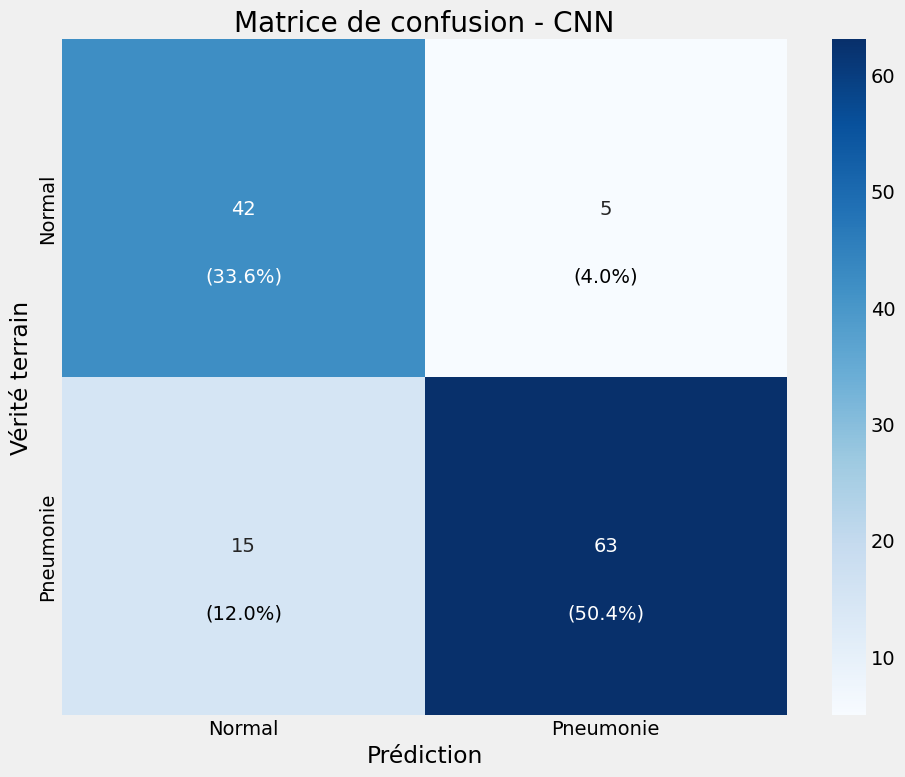

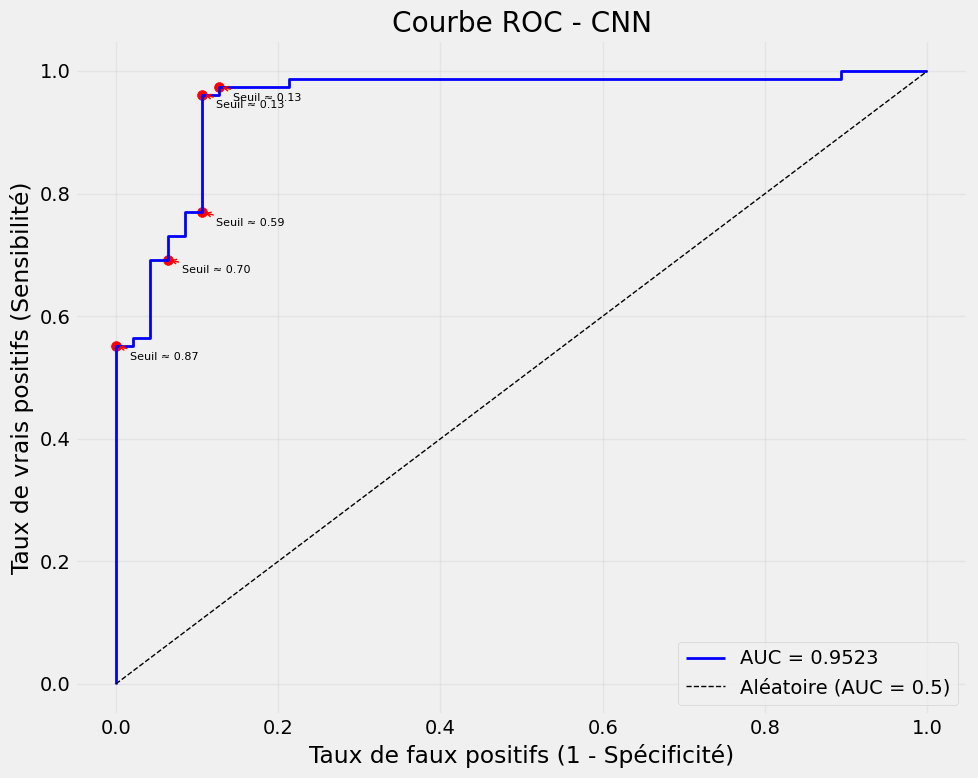

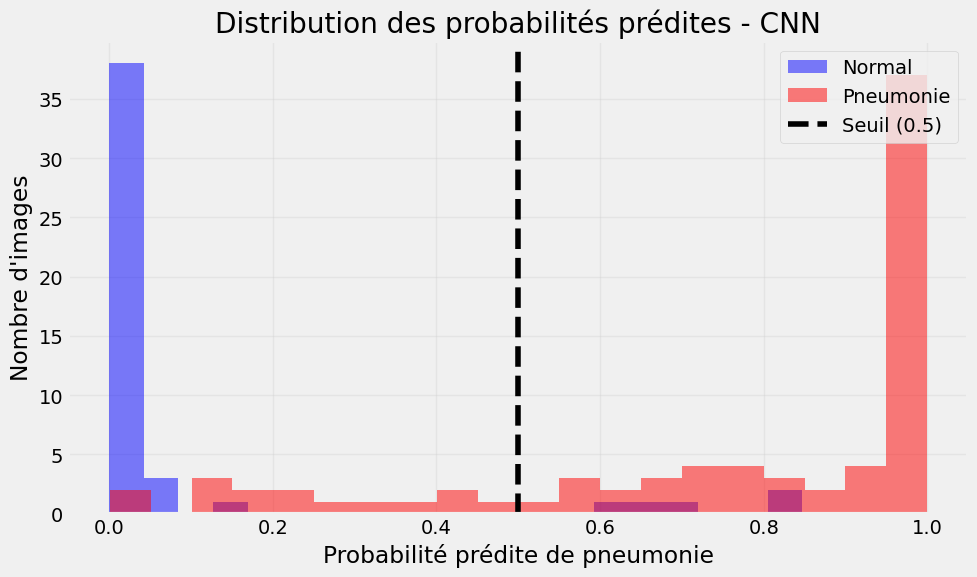

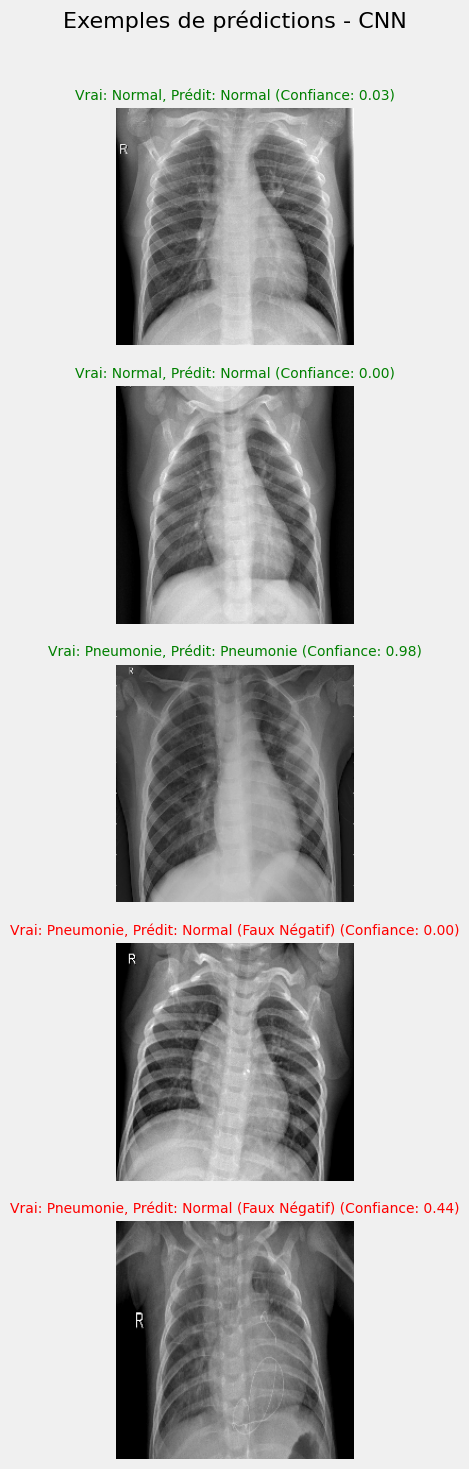


Évaluation du modèle VGG16...
Prédiction sur 125 images de test (batch_size=16)...
8/8 [==============================] - 19s 2s/step

=== Résultats d'évaluation pour VGG16 ===
Accuracy: 0.8880
Precision: 0.8636
Recall (Sensibilité): 0.9744
Specificity: 0.7447
F1-score: 0.9157
AUC: 0.9253
Valeur prédictive négative: 0.9459

Matrice de confusion:
[[35 12]
 [ 2 76]]

Détails de la matrice de confusion:
Vrais Négatifs (Normal correctement identifié): 35 (28.0%)
Faux Positifs (Normal prédit comme Pneumonie): 12 (9.6%)
Faux Négatifs (Pneumonie prédite comme Normal): 2 (1.6%)
Vrais Positifs (Pneumonie correctement identifiée): 76 (60.8%)

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.95      0.74      0.83        47
   Pneumonie       0.86      0.97      0.92        78

    accuracy                           0.89       125
   macro avg       0.90      0.86      0.87       125
weighted avg       0.89      0.89      0.88       125



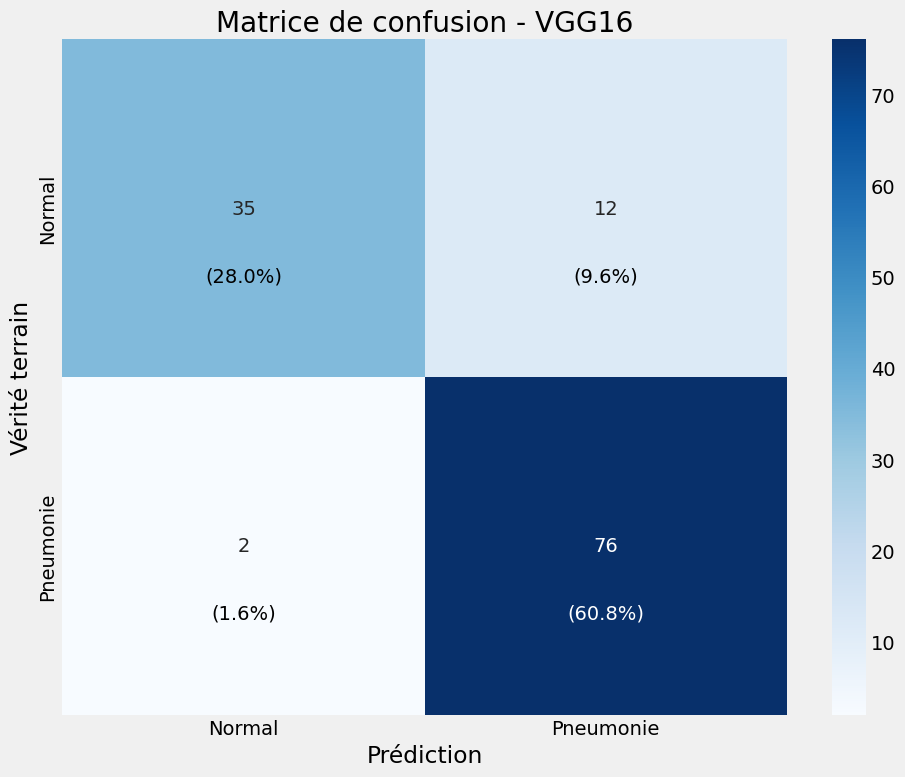

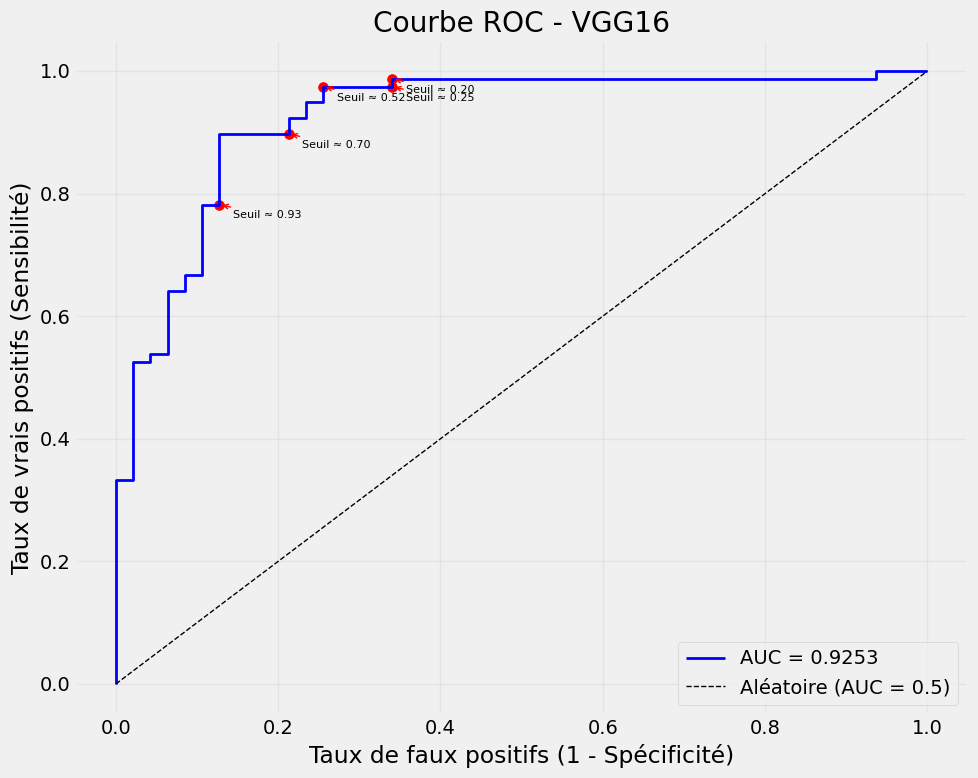

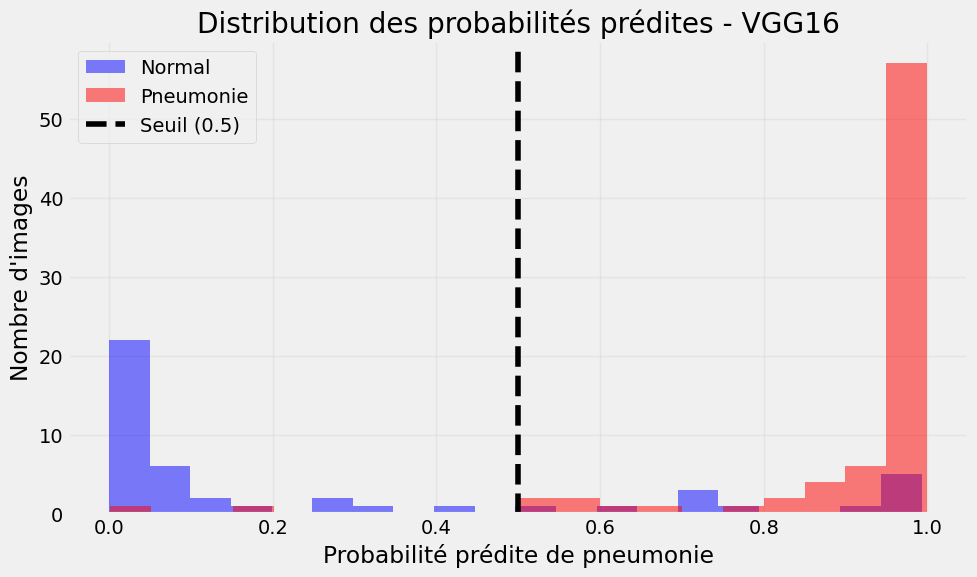

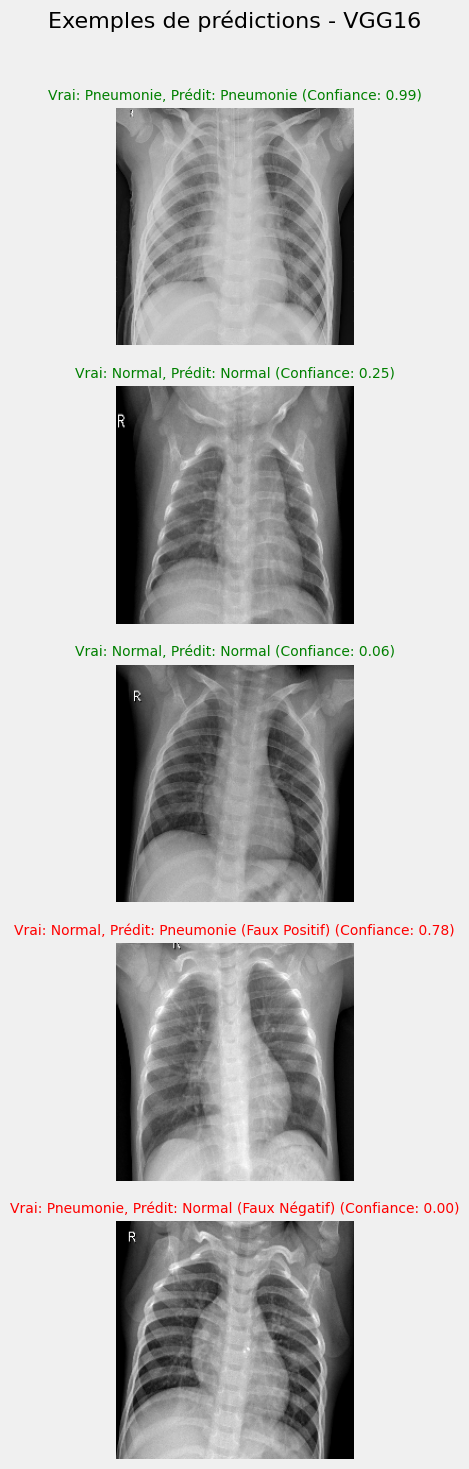


Évaluation du modèle ResNet50...
Prédiction sur 125 images de test (batch_size=16)...
8/8 [==============================] - 9s 945ms/step

=== Résultats d'évaluation pour ResNet50 ===
Accuracy: 0.8320
Precision: 0.9130
Recall (Sensibilité): 0.8077
Specificity: 0.8723
F1-score: 0.8571
AUC: 0.9389
Valeur prédictive négative: 0.7321

Matrice de confusion:
[[41  6]
 [15 63]]

Détails de la matrice de confusion:
Vrais Négatifs (Normal correctement identifié): 41 (32.8%)
Faux Positifs (Normal prédit comme Pneumonie): 6 (4.8%)
Faux Négatifs (Pneumonie prédite comme Normal): 15 (12.0%)
Vrais Positifs (Pneumonie correctement identifiée): 63 (50.4%)

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.73      0.87      0.80        47
   Pneumonie       0.91      0.81      0.86        78

    accuracy                           0.83       125
   macro avg       0.82      0.84      0.83       125
weighted avg       0.85      0.83      0.83       

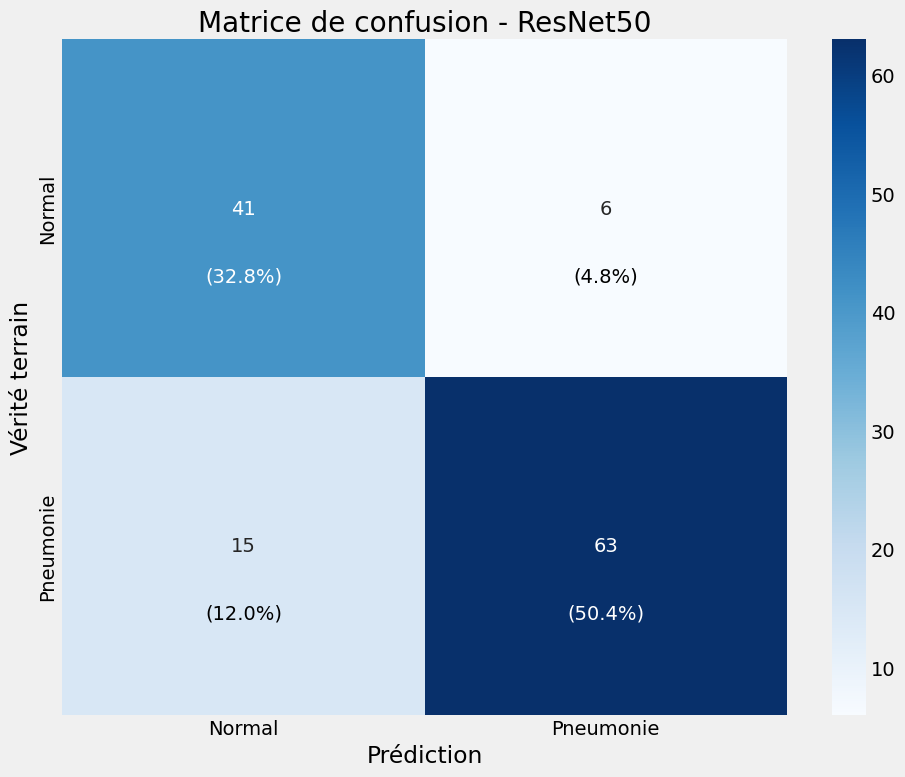

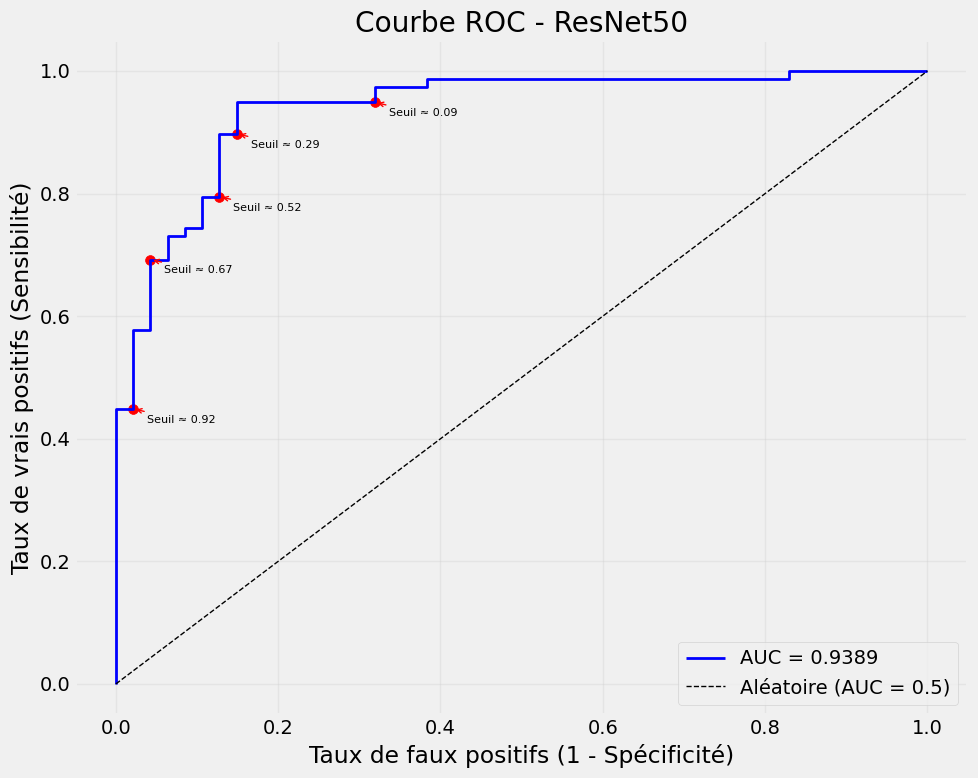

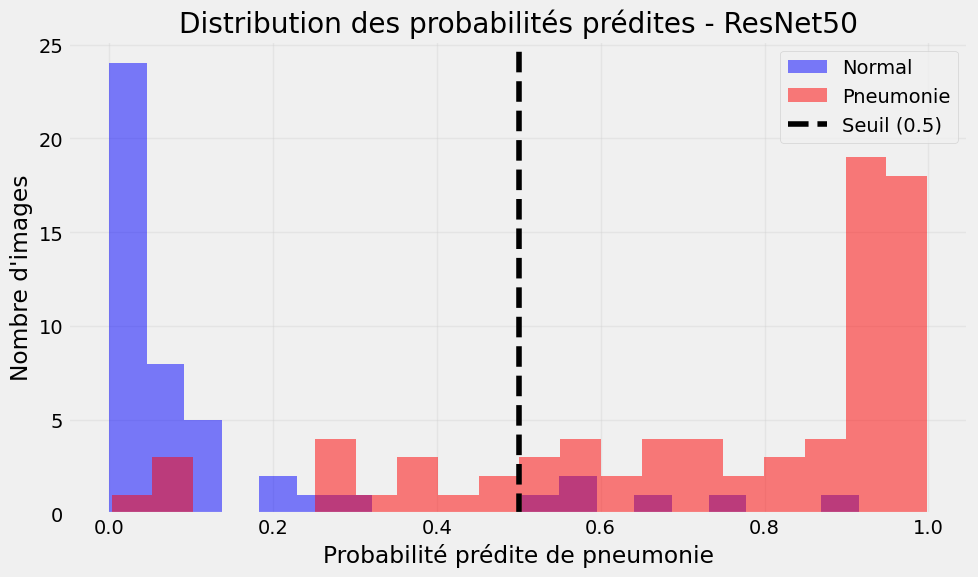

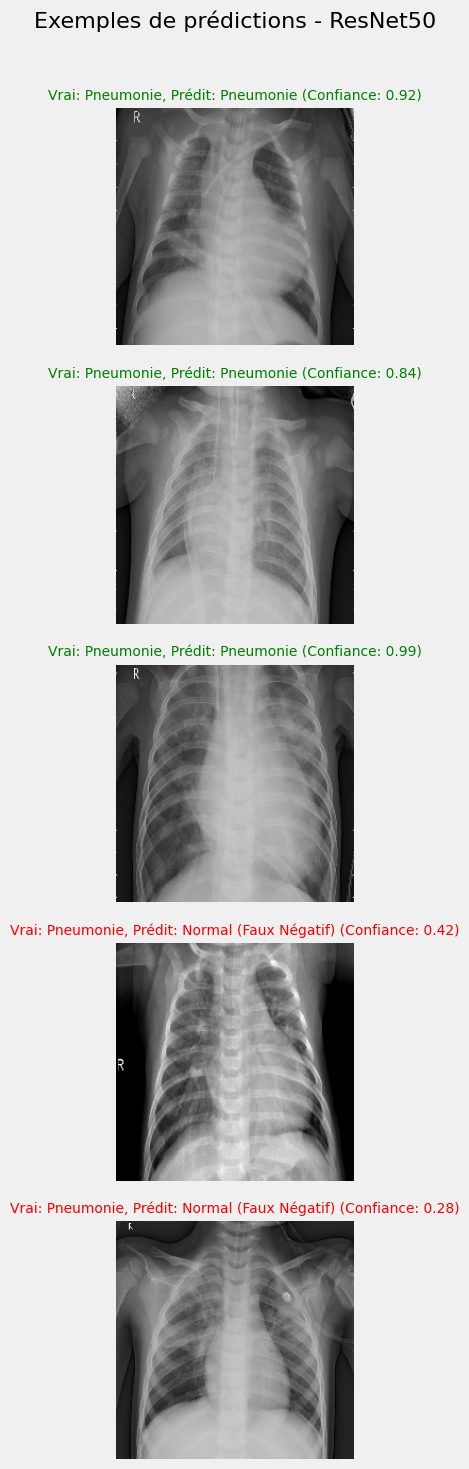


Comparaison des métriques:
          accuracy  precision    recall  specificity  f1_score       auc  \
CNN          0.840   0.926471  0.807692     0.893617  0.863014  0.952264   
VGG16        0.888   0.863636  0.974359     0.744681  0.915663  0.925259   
ResNet50     0.832   0.913043  0.807692     0.872340  0.857143  0.938898   

               npv  
CNN       0.736842  
VGG16     0.945946  
ResNet50  0.732143  


<Figure size 1200x800 with 0 Axes>

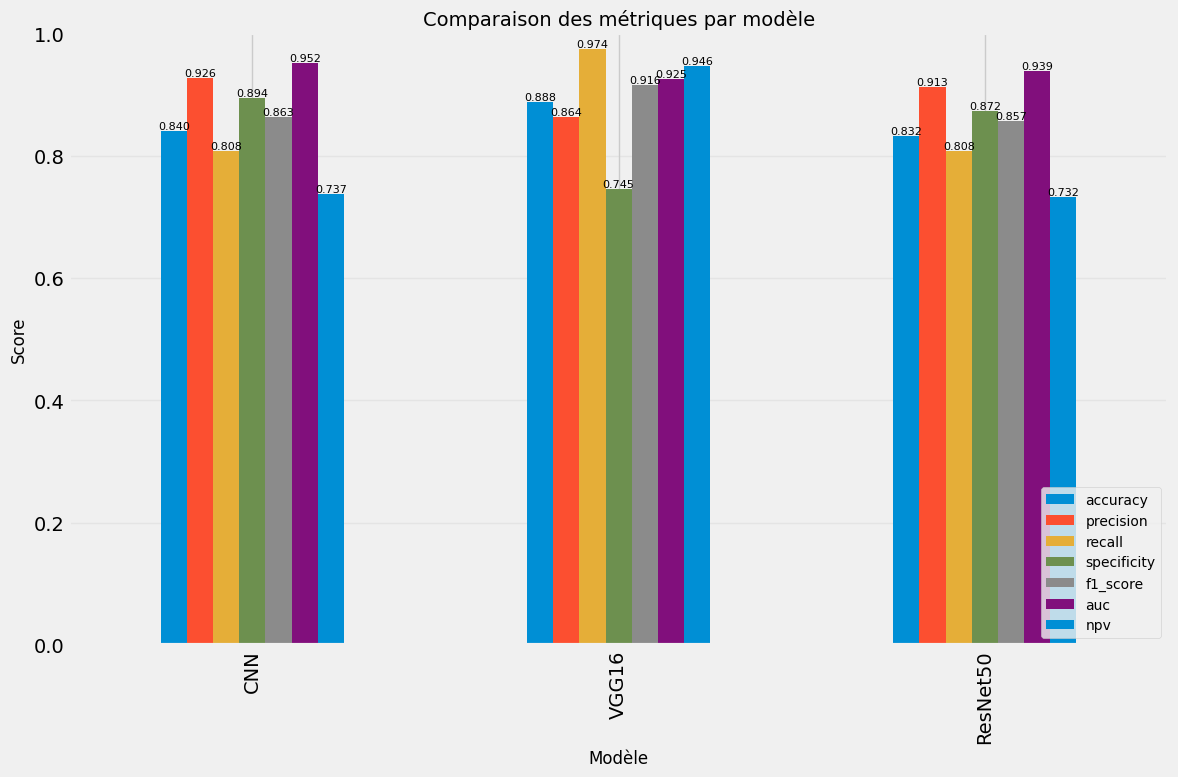

Résultats sauvegardés dans C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results\model_comparison.csv


In [4]:
def evaluate_model(model, X_test, y_test, model_name='Modèle', batch_size=32):
    """
    Évalue les performances d'un modèle.
    
    Args:
        model: Modèle à évaluer
        X_test (numpy.ndarray): Images de test
        y_test (numpy.ndarray): Étiquettes de test
        model_name (str): Nom du modèle
        batch_size (int): Taille du batch pour les prédictions
        
    Returns:
        tuple: Métriques d'évaluation et probabilités prédites
    """
    if model is None:
        print(f"Le modèle {model_name} n'est pas disponible.")
        return None, None
    
    if len(X_test) == 0 or len(y_test) == 0:
        print(f"Les données de test sont vides. Impossible d'évaluer le modèle {model_name}.")
        return None, None
    
    try:
        # Ajuster la taille du batch pour les modèles volumineux
        if 'vgg' in model_name.lower() or 'resnet' in model_name.lower():
            batch_size = min(batch_size, 16)  # Réduire la taille du batch pour les modèles volumineux
        
        # Faire des prédictions
        print(f"Prédiction sur {len(X_test)} images de test (batch_size={batch_size})...")
        y_pred_proba = model.predict(X_test, batch_size=batch_size, verbose=1).flatten()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Calculer les métriques de base
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba)
        }
        
        # Calculer des métriques supplémentaires à partir de la matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Spécificité: capacité à identifier correctement les cas négatifs
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # Valeur prédictive négative: probabilité qu'un résultat négatif soit correct
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        # Ajouter ces métriques au dictionnaire
        metrics['specificity'] = specificity
        metrics['npv'] = npv  # Negative Predictive Value
        
        # Afficher les résultats
        print(f"\n{'='*50}")
        print(f"=== Résultats d'évaluation pour {model_name} ===")
        print(f"{'='*50}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall (Sensibilité): {metrics['recall']:.4f}")
        print(f"Specificity: {metrics['specificity']:.4f}")
        print(f"F1-score: {metrics['f1_score']:.4f}")
        print(f"AUC: {metrics['auc']:.4f}")
        print(f"Valeur prédictive négative: {metrics['npv']:.4f}")
        
        # Matrice de confusion
        print("\nMatrice de confusion:")
        print(cm)
        
        # Détails de la matrice de confusion
        total = tn + fp + fn + tp
        print("\nDétails de la matrice de confusion:")
        print(f"Vrais Négatifs (Normal correctement identifié): {tn} ({tn/total*100:.1f}%)")
        print(f"Faux Positifs (Normal prédit comme Pneumonie): {fp} ({fp/total*100:.1f}%)")
        print(f"Faux Négatifs (Pneumonie prédite comme Normal): {fn} ({fn/total*100:.1f}%)")
        print(f"Vrais Positifs (Pneumonie correctement identifiée): {tp} ({tp/total*100:.1f}%)")
        
        # Rapport de classification
        print("\nRapport de classification:")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonie']))
        
        # Visualiser la matrice de confusion
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Normal', 'Pneumonie'], 
                    yticklabels=['Normal', 'Pneumonie'])
        
        # Ajouter les pourcentages
        for i in range(2):
            for j in range(2):
                plt.text(j + 0.5, i + 0.7, f'({cm[i, j]/np.sum(cm)*100:.1f}%)', 
                         ha='center', va='center', color='black' if cm[i, j] < cm.max()/2 else 'white')
        
        plt.xlabel('Prédiction')
        plt.ylabel('Vérité terrain')
        plt.title(f'Matrice de confusion - {model_name}')
        plt.tight_layout()
        plt.show()
        
        # Courbe ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {metrics["auc"]:.4f}')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aléatoire (AUC = 0.5)')
        plt.xlabel('Taux de faux positifs (1 - Spécificité)')
        plt.ylabel('Taux de vrais positifs (Sensibilité)')
        plt.title(f'Courbe ROC - {model_name}')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        
        # Ajouter quelques points de seuil sur la courbe ROC
        threshold_points = [0.1, 0.3, 0.5, 0.7, 0.9]
        threshold_indices = []
        
        for t in threshold_points:
            # Trouver l'indice du seuil le plus proche
            if t >= min(thresholds) and t <= max(thresholds):
                idx = np.argmin(np.abs(thresholds - t))
                threshold_indices.append(idx)
                
        # Marquer les points de seuil sur la courbe
        if threshold_indices:
            plt.scatter(fpr[threshold_indices], tpr[threshold_indices], c='red', s=50)
            
            # Ajouter les annotations pour les seuils
            for i, idx in enumerate(threshold_indices):
                plt.annotate(f'Seuil ≈ {thresholds[idx]:.2f}', 
                            (fpr[idx], tpr[idx]), 
                            xytext=(10, -10), 
                            textcoords='offset points',
                            fontsize=8,
                            arrowprops=dict(arrowstyle='->', color='red', lw=1))
        
        plt.tight_layout()
        plt.show()
        
        # Visualiser la distribution des probabilités prédites
        plt.figure(figsize=(10, 6))
        
        # Séparer les prédictions par classe réelle
        normal_probs = y_pred_proba[y_test == 0]
        pneumonia_probs = y_pred_proba[y_test == 1]
        
        # Tracer les histogrammes
        plt.hist(normal_probs, bins=20, alpha=0.5, color='blue', label='Normal')
        plt.hist(pneumonia_probs, bins=20, alpha=0.5, color='red', label='Pneumonie')
        
        plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil (0.5)')
        plt.xlabel('Probabilité prédite de pneumonie')
        plt.ylabel('Nombre d\'images')
        plt.title(f'Distribution des probabilités prédites - {model_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Visualiser quelques exemples de prédictions
        num_examples = min(5, len(X_test))
        
        # Sélectionner des exemples variés (corrects et incorrects)
        correct_indices = np.where(y_pred == y_test)[0]
        incorrect_indices = np.where(y_pred != y_test)[0]
        
        # Déterminer combien d'exemples de chaque type à afficher
        num_incorrect = min(num_examples // 2, len(incorrect_indices))
        num_correct = num_examples - num_incorrect
        
        # Sélectionner les indices
        selected_indices = []
        
        if num_correct > 0 and len(correct_indices) > 0:
            selected_indices.extend(np.random.choice(correct_indices, num_correct, replace=False))
        
        if num_incorrect > 0 and len(incorrect_indices) > 0:
            selected_indices.extend(np.random.choice(incorrect_indices, num_incorrect, replace=False))
        
        # Si nous n'avons pas assez d'exemples, compléter avec des exemples aléatoires
        if len(selected_indices) < num_examples:
            remaining = num_examples - len(selected_indices)
            all_indices = np.arange(len(X_test))
            remaining_indices = np.setdiff1d(all_indices, selected_indices)
            if len(remaining_indices) > 0:
                selected_indices.extend(np.random.choice(remaining_indices, min(remaining, len(remaining_indices)), replace=False))
        
        # Visualiser les exemples
        plt.figure(figsize=(15, 3 * min(num_examples, len(selected_indices))))
        
        for i, idx in enumerate(selected_indices):
            plt.subplot(min(num_examples, len(selected_indices)), 1, i+1)
            
            # Afficher l'image
            plt.imshow(X_test[idx])
            
            # Déterminer la couleur en fonction de la prédiction
            is_correct = y_pred[idx] == y_test[idx]
            color = 'green' if is_correct else 'red'
            
            # Déterminer les libellés des classes
            true_label = 'Pneumonie' if y_test[idx] == 1 else 'Normal'
            pred_label = 'Pneumonie' if y_pred[idx] == 1 else 'Normal'
            
            # Ajouter le type d'erreur si la prédiction est incorrecte
            error_type = ""
            if not is_correct:
                if y_test[idx] == 0 and y_pred[idx] == 1:
                    error_type = " (Faux Positif)"
                else:
                    error_type = " (Faux Négatif)"
            
            # Afficher le titre avec les informations de prédiction
            plt.title(f"Vrai: {true_label}, Prédit: {pred_label}{error_type} (Confiance: {y_pred_proba[idx]:.2f})", 
                     color=color, fontsize=10)
            
            # Désactiver les axes
            plt.axis('off')
        
        plt.suptitle(f'Exemples de prédictions - {model_name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
        
        return metrics, y_pred_proba
    
    except Exception as e:
        print(f"Erreur lors de l'évaluation du modèle {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Évaluer chaque modèle
results = {}
probas = {}

if len(models) == 0:
    print("Aucun modèle n'est disponible pour l'évaluation.")
elif X_test is None or y_test is None or len(X_test) == 0 or len(y_test) == 0:
    print("Les données de test ne sont pas disponibles. Impossible d'évaluer les modèles.")
else:
    for model_name, model in models.items():
        print(f"\nÉvaluation du modèle {model_name}...")
        
        # Libérer la mémoire avant l'évaluation
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Évaluer le modèle
        metrics, y_pred_proba = evaluate_model(model, X_test, y_test, model_name)
        
        if metrics is not None:
            results[model_name] = metrics
            probas[model_name] = y_pred_proba
        
        # Libérer la mémoire après l'évaluation
        gc.collect()
        tf.keras.backend.clear_session()
    
    # Créer un DataFrame pour comparer les métriques
    if results:
        metrics_df = pd.DataFrame(results).T
        
        # Réorganiser les colonnes pour un affichage plus logique
        cols_order = ['accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc', 'npv']
        metrics_df = metrics_df[cols_order]
        
        # Afficher le tableau de comparaison
        print("\nComparaison des métriques:")
        print("=" * 50)
        print(metrics_df)
        
        # Visualiser les métriques sous forme de graphique à barres
        plt.figure(figsize=(12, 8))
        ax = metrics_df.plot(kind='bar', figsize=(12, 8))
        plt.title('Comparaison des métriques par modèle', fontsize=14)
        plt.xlabel('Modèle', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.ylim(0, 1)
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(axis='y', alpha=0.3)
        
        # Ajouter les valeurs sur les barres
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', fontsize=8)
            
        plt.tight_layout()
        plt.show()
        
        # Sauvegarder les résultats
        try:
            results_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results'
            os.makedirs(results_dir, exist_ok=True)
            metrics_df.to_csv(os.path.join(results_dir, 'model_comparison.csv'))
            print(f"Résultats sauvegardés dans {os.path.join(results_dir, 'model_comparison.csv')}")
        except Exception as e:
            print(f"Erreur lors de la sauvegarde des résultats: {e}")

## 4. Comparaison des modèles

Nous allons comparer les performances des différents modèles.


Comparaison des métriques:
          accuracy  precision  recall  specificity  f1_score     auc     npv
CNN          0.840     0.9265  0.8077       0.8936    0.8630  0.9523  0.7368
VGG16        0.888     0.8636  0.9744       0.7447    0.9157  0.9253  0.9459
ResNet50     0.832     0.9130  0.8077       0.8723    0.8571  0.9389  0.7321

Tableau formaté (les valeurs plus élevées sont en bleu plus foncé):
          accuracy  precision  recall  specificity  f1_score     auc     npv
CNN          0.840     0.9265  0.8077       0.8936    0.8630  0.9523  0.7368
VGG16        0.888     0.8636  0.9744       0.7447    0.9157  0.9253  0.9459
ResNet50     0.832     0.9130  0.8077       0.8723    0.8571  0.9389  0.7321


<Figure size 1400x800 with 0 Axes>

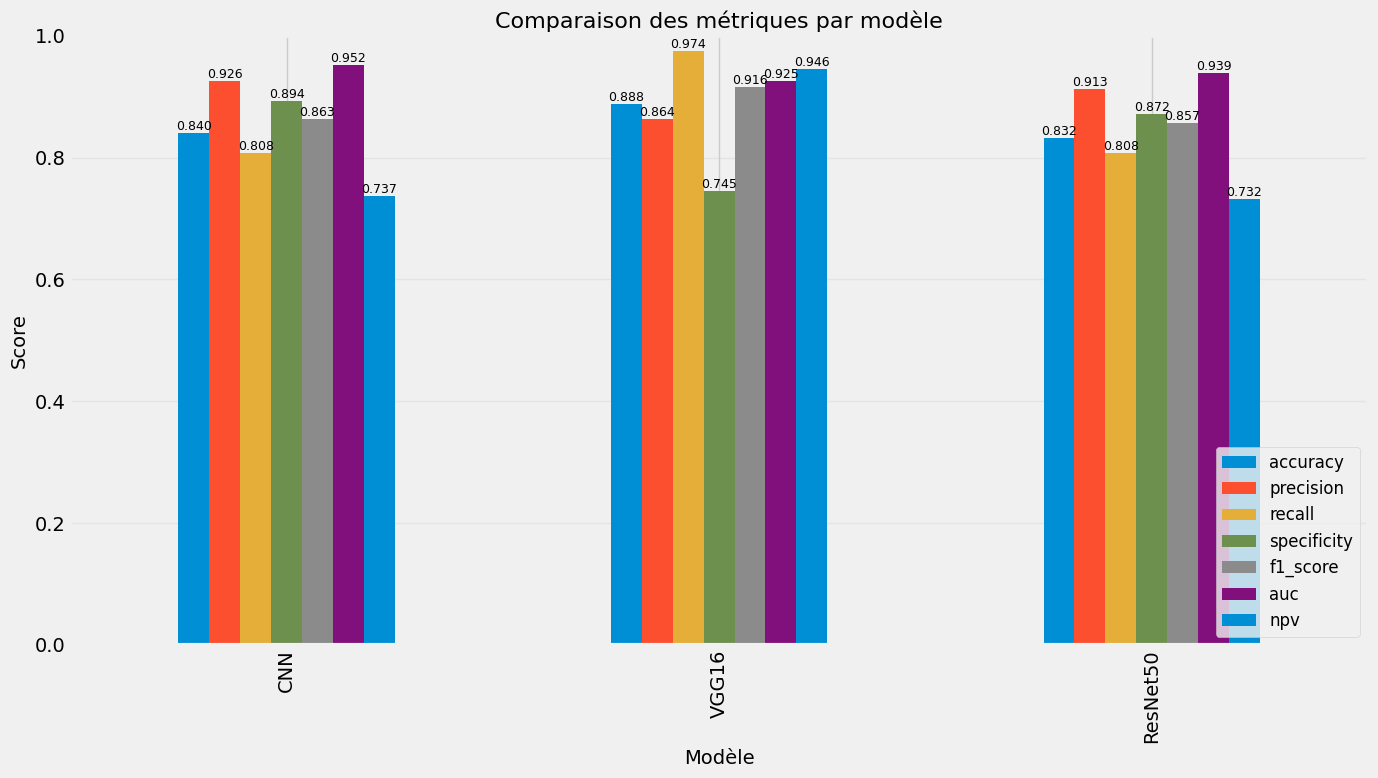

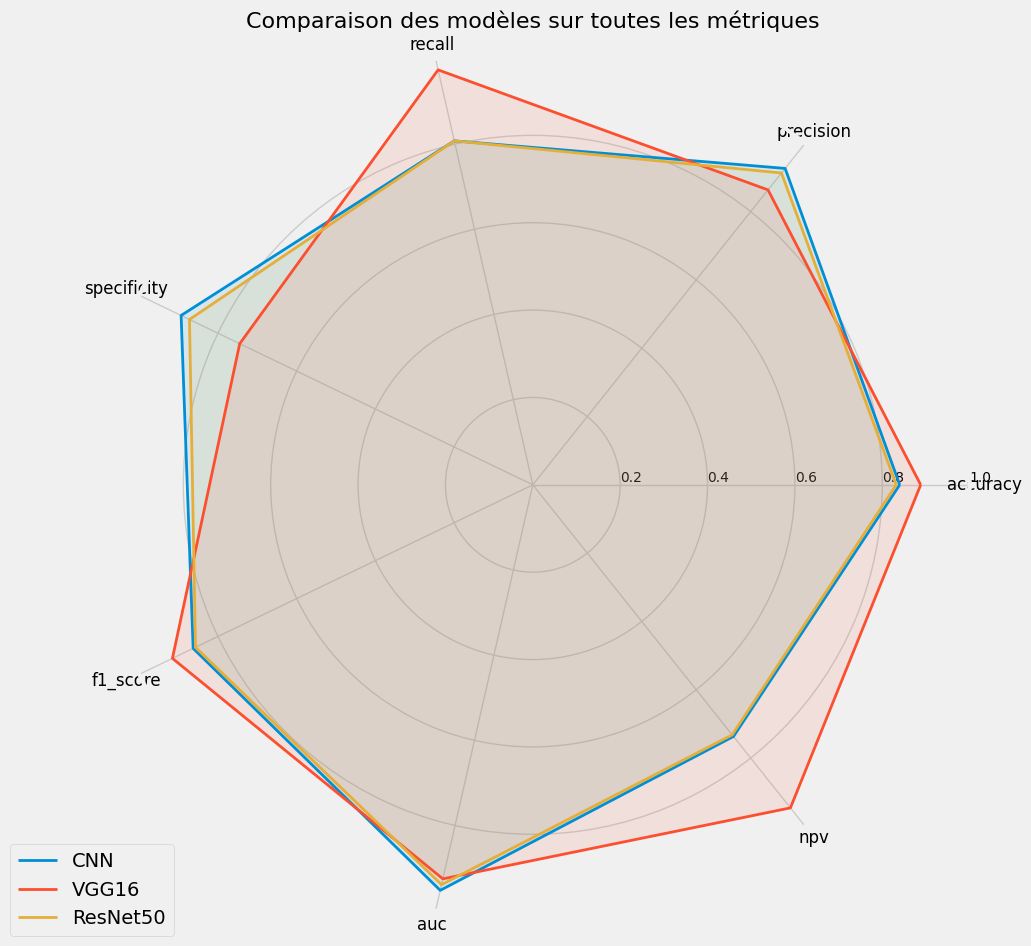

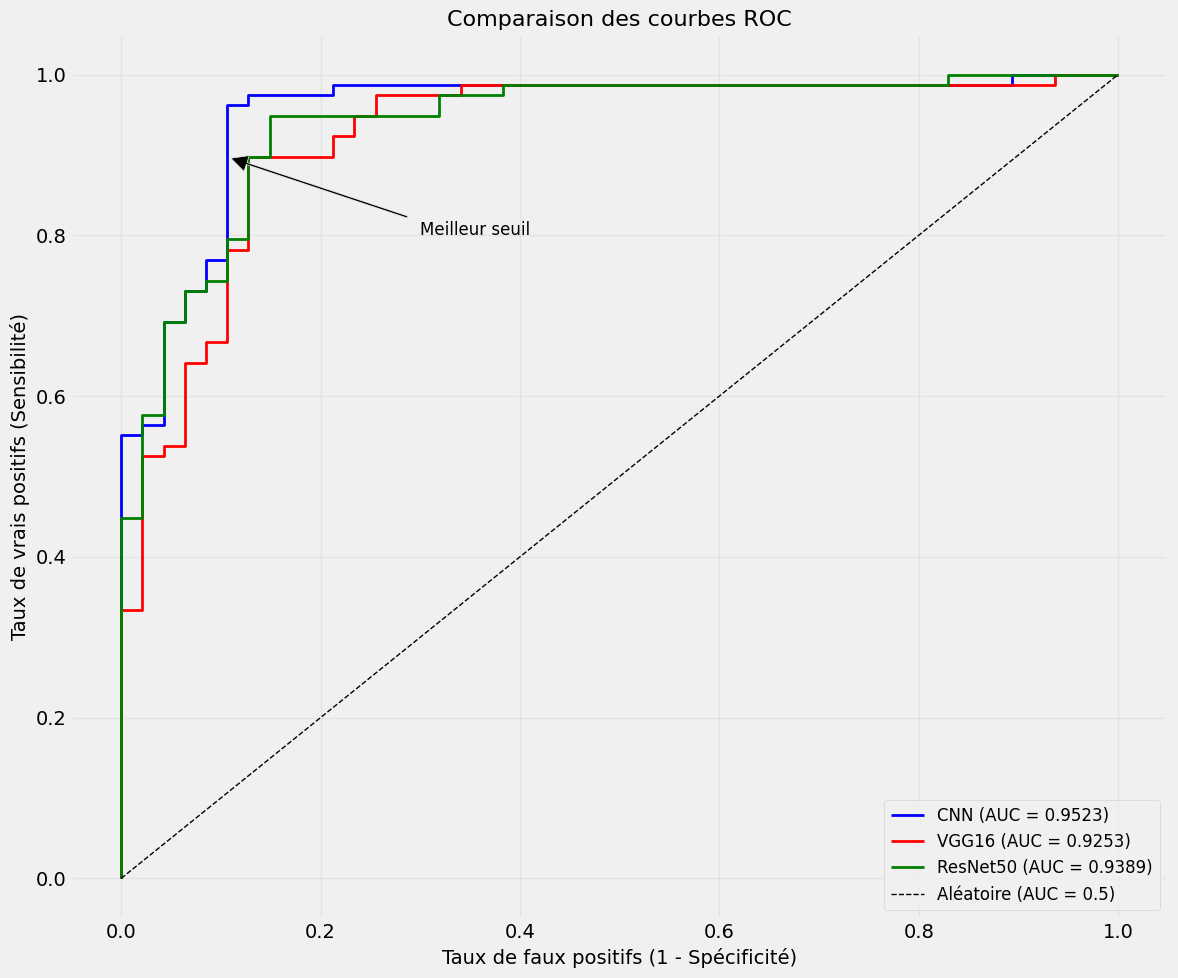

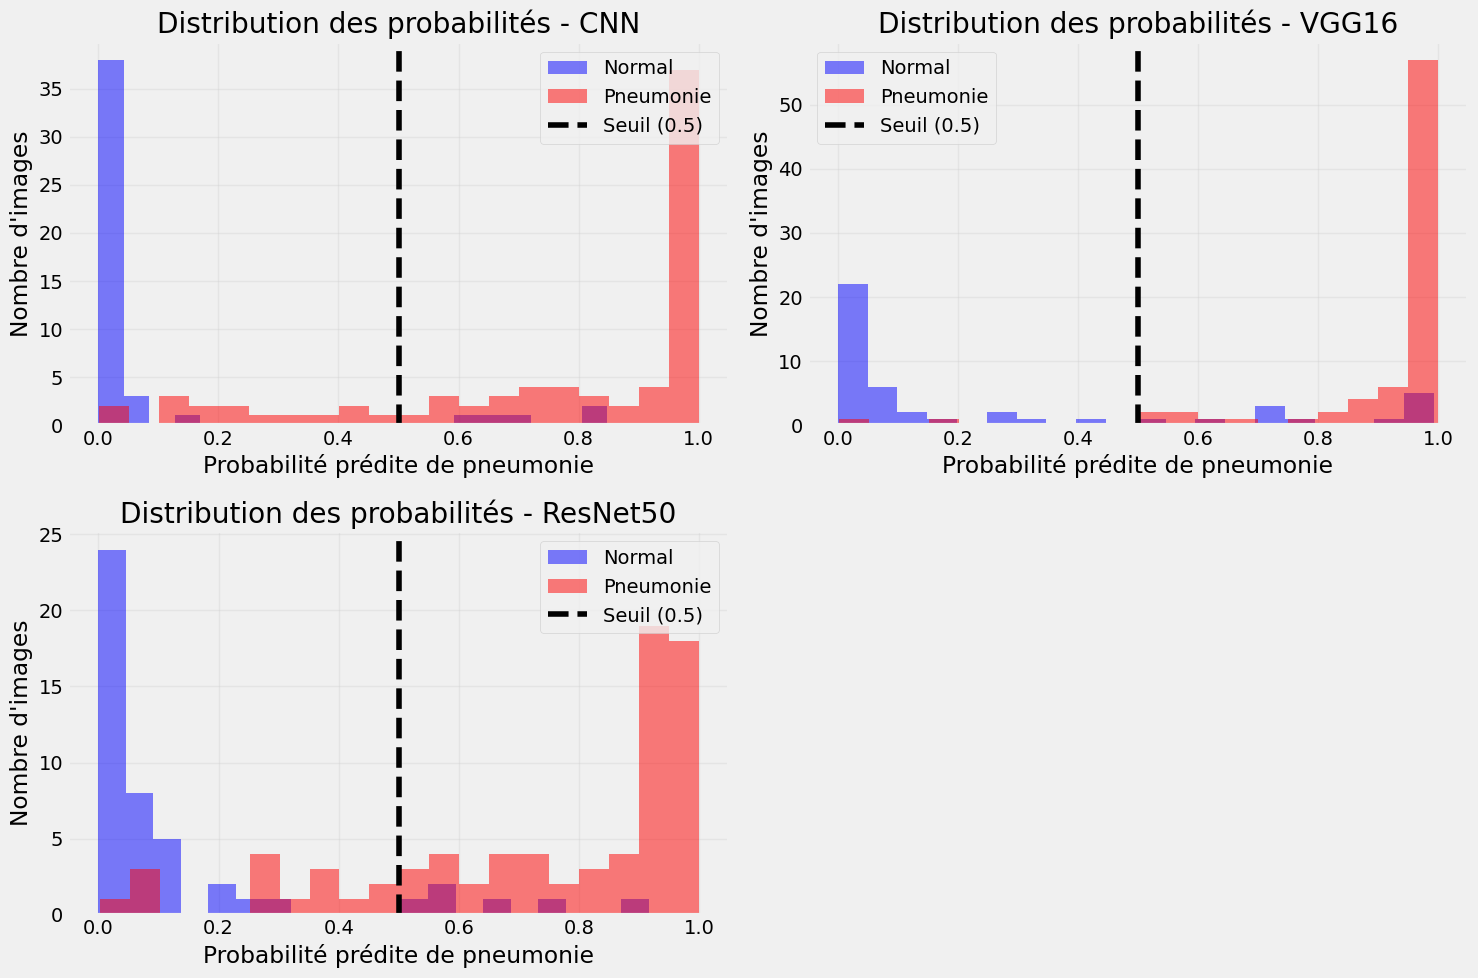

Résultats sauvegardés dans C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results\model_comparison.csv
Probabilités prédites sauvegardées dans C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results\predicted_probabilities.csv


In [5]:
# Vérifier si nous avons des résultats à comparer
if not results:
    print("Aucun résultat d'évaluation disponible pour la comparaison.")
else:
    try:
        # Créer un DataFrame pour comparer les métriques
        metrics_df = pd.DataFrame(results).T
        
        # Vérifier quelles métriques sont disponibles
        available_metrics = metrics_df.columns.tolist()
        desired_metrics = ['accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc', 'npv']
        metrics_to_use = [m for m in desired_metrics if m in available_metrics]
        
        if not metrics_to_use:
            print("Aucune métrique commune n'est disponible pour la comparaison.")
        else:
            # Sélectionner les métriques disponibles
            metrics_df = metrics_df[metrics_to_use]
            
            # Afficher le tableau de comparaison
            print("\nComparaison des métriques:")
            print("=" * 80)
            print(metrics_df.round(4))  # Arrondir à 4 décimales pour une meilleure lisibilité
            
            # Créer un tableau formaté plus lisible
            styled_df = metrics_df.style.format("{:.4f}")
            styled_df = styled_df.background_gradient(cmap='Blues')
            
            # Dans un notebook, vous utiliseriez display(styled_df)
            # Mais comme nous sommes dans un script, nous utilisons print
            print("\nTableau formaté (les valeurs plus élevées sont en bleu plus foncé):")
            print(metrics_df.round(4).to_string())
            
            # Visualiser les métriques sous forme de graphique à barres
            plt.figure(figsize=(14, 8))
            ax = metrics_df.plot(kind='bar', figsize=(14, 8))
            plt.title('Comparaison des métriques par modèle', fontsize=16)
            plt.xlabel('Modèle', fontsize=14)
            plt.ylabel('Score', fontsize=14)
            plt.ylim(0, 1)
            plt.legend(loc='lower right', fontsize=12)
            plt.grid(axis='y', alpha=0.3)
            
            # Ajouter les valeurs sur les barres
            for container in ax.containers:
                ax.bar_label(container, fmt='%.3f', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            # Créer un graphique radar pour comparer les modèles sur toutes les métriques
            # Cette visualisation est particulièrement utile pour comparer plusieurs métriques à la fois
            plt.figure(figsize=(10, 10))
            
            # Nombre de métriques
            N = len(metrics_to_use)
            
            # Angle pour chaque métrique
            angles = [n / float(N) * 2 * np.pi for n in range(N)]
            angles += angles[:1]  # Fermer le graphique
            
            # Initialiser le graphique radar
            ax = plt.subplot(111, polar=True)
            
            # Ajouter les étiquettes des métriques
            plt.xticks(angles[:-1], metrics_to_use, size=12)
            
            # Ajouter les lignes de grille
            ax.set_rlabel_position(0)
            plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
            plt.ylim(0, 1)
            
            # Tracer les données pour chaque modèle
            for model_name in metrics_df.index:
                values = metrics_df.loc[model_name].values.tolist()
                values += values[:1]  # Fermer le graphique
                ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
                ax.fill(angles, values, alpha=0.1)
            
            # Ajouter la légende
            plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
            plt.title('Comparaison des modèles sur toutes les métriques', size=16)
            plt.tight_layout()
            plt.show()
            
            # Tracer les courbes ROC pour tous les modèles
            if probas:
                plt.figure(figsize=(12, 10))
                
                # Couleurs pour chaque modèle
                colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
                
                for i, (model_name, y_pred_proba) in enumerate(probas.items()):
                    if y_pred_proba is not None and len(y_pred_proba) > 0:
                        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                        auc = roc_auc_score(y_test, y_pred_proba)
                        color = colors[i % len(colors)]
                        plt.plot(fpr, tpr, color=color, linewidth=2, 
                                label=f'{model_name} (AUC = {auc:.4f})')
                
                plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aléatoire (AUC = 0.5)')
                plt.xlabel('Taux de faux positifs (1 - Spécificité)', fontsize=14)
                plt.ylabel('Taux de vrais positifs (Sensibilité)', fontsize=14)
                plt.title('Comparaison des courbes ROC', fontsize=16)
                plt.legend(loc='lower right', fontsize=12)
                plt.grid(True, alpha=0.3)
                
                # Ajouter des annotations pour les points clés
                plt.annotate('Meilleur seuil', xy=(0.1, 0.9), xytext=(0.3, 0.8),
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                            fontsize=12)
                
                plt.tight_layout()
                plt.show()
                
                # Visualiser la distribution des probabilités prédites pour chaque modèle
                plt.figure(figsize=(15, 10))
                
                # Créer une grille de sous-graphiques
                num_models = len(probas)
                rows = (num_models + 1) // 2  # Arrondir vers le haut
                cols = min(2, num_models)
                
                for i, (model_name, y_pred_proba) in enumerate(probas.items()):
                    if y_pred_proba is not None and len(y_pred_proba) > 0:
                        plt.subplot(rows, cols, i+1)
                        
                        # Séparer les prédictions par classe réelle
                        normal_probs = y_pred_proba[y_test == 0]
                        pneumonia_probs = y_pred_proba[y_test == 1]
                        
                        # Tracer les histogrammes
                        plt.hist(normal_probs, bins=20, alpha=0.5, color='blue', label='Normal')
                        plt.hist(pneumonia_probs, bins=20, alpha=0.5, color='red', label='Pneumonie')
                        
                        plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil (0.5)')
                        plt.xlabel('Probabilité prédite de pneumonie')
                        plt.ylabel('Nombre d\'images')
                        plt.title(f'Distribution des probabilités - {model_name}')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                # Sauvegarder les résultats
                try:
                    results_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results'
                    os.makedirs(results_dir, exist_ok=True)
                    
                    # Sauvegarder le tableau de comparaison
                    metrics_df.to_csv(os.path.join(results_dir, 'model_comparison.csv'))
                    print(f"Résultats sauvegardés dans {os.path.join(results_dir, 'model_comparison.csv')}")
                    
                    # Sauvegarder les probabilités prédites
                    probas_df = pd.DataFrame(probas)
                    probas_df['true_label'] = y_test
                    probas_df.to_csv(os.path.join(results_dir, 'predicted_probabilities.csv'))
                    print(f"Probabilités prédites sauvegardées dans {os.path.join(results_dir, 'predicted_probabilities.csv')}")
                except Exception as e:
                    print(f"Erreur lors de la sauvegarde des résultats: {e}")
            else:
                print("Aucune probabilité prédite n'est disponible pour tracer les courbes ROC.")
    except Exception as e:
        print(f"Erreur lors de la comparaison des modèles: {e}")
        import traceback
        traceback.print_exc()

## 5. Visualisation des prédictions

Nous allons visualiser quelques exemples de prédictions pour mieux comprendre les performances des modèles.


Prédictions du modèle CNN:
Prédiction sur 125 images de test...
Accuracy globale: 0.8400
Accuracy pour la classe 'Normal': 0.8936
Accuracy pour la classe 'Pneumonie': 0.8077


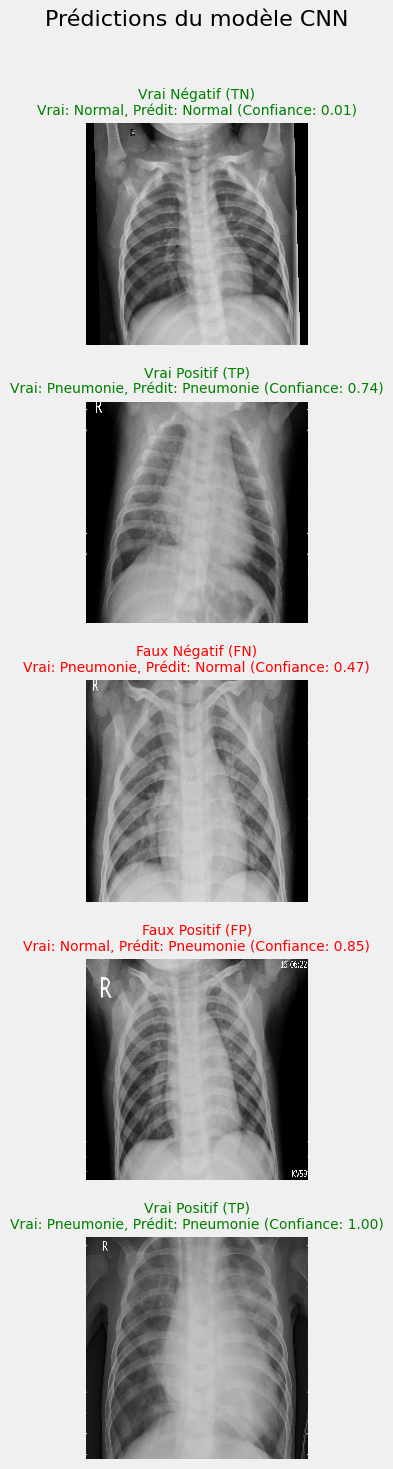


Résumé des performances:
Matrice de confusion:
  Vrais Négatifs (TN): 42 (33.6%)
  Faux Positifs (FP): 5 (4.0%)
  Faux Négatifs (FN): 15 (12.0%)
  Vrais Positifs (TP): 63 (50.4%)

Métriques:
  Précision: 0.9265
  Rappel (Sensibilité): 0.8077
  Spécificité: 0.8936
  F1-score: 0.8630

Prédictions du modèle VGG16:
Prédiction sur 125 images de test...
Accuracy globale: 0.8880
Accuracy pour la classe 'Normal': 0.7447
Accuracy pour la classe 'Pneumonie': 0.9744


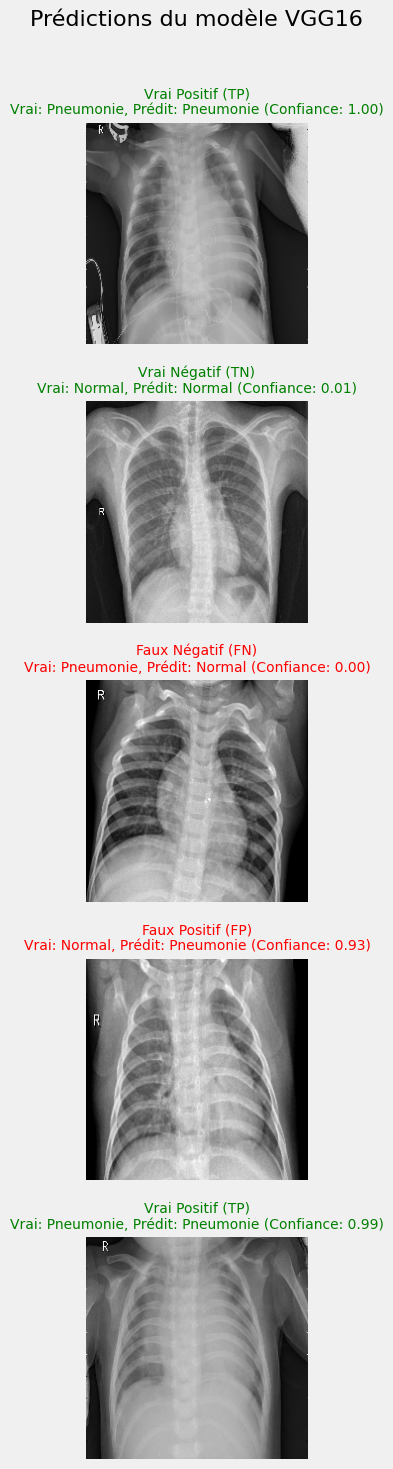


Résumé des performances:
Matrice de confusion:
  Vrais Négatifs (TN): 35 (28.0%)
  Faux Positifs (FP): 12 (9.6%)
  Faux Négatifs (FN): 2 (1.6%)
  Vrais Positifs (TP): 76 (60.8%)

Métriques:
  Précision: 0.8636
  Rappel (Sensibilité): 0.9744
  Spécificité: 0.7447
  F1-score: 0.9157

Prédictions du modèle ResNet50:
Prédiction sur 125 images de test...
Accuracy globale: 0.8320
Accuracy pour la classe 'Normal': 0.8723
Accuracy pour la classe 'Pneumonie': 0.8077


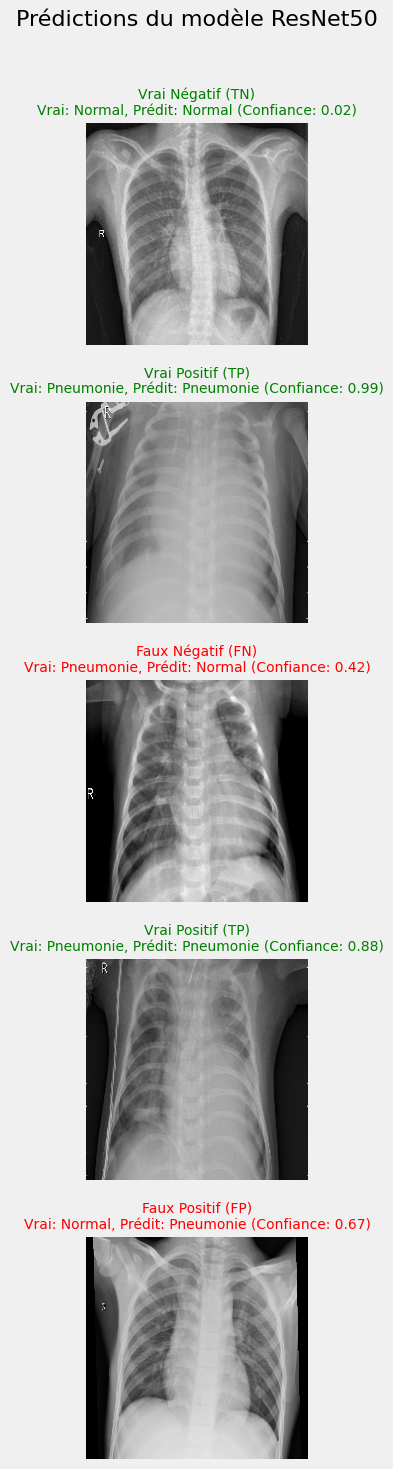


Résumé des performances:
Matrice de confusion:
  Vrais Négatifs (TN): 41 (32.8%)
  Faux Positifs (FP): 6 (4.8%)
  Faux Négatifs (FN): 15 (12.0%)
  Vrais Positifs (TP): 63 (50.4%)

Métriques:
  Précision: 0.9130
  Rappel (Sensibilité): 0.8077
  Spécificité: 0.8723
  F1-score: 0.8571


In [6]:
def visualize_predictions(model, X_test, y_test, model_name='Modèle', num_samples=5):
    """
    Visualise quelques prédictions du modèle.
    
    Args:
        model: Modèle à utiliser pour les prédictions
        X_test (numpy.ndarray): Images de test
        y_test (numpy.ndarray): Étiquettes de test
        model_name (str): Nom du modèle
        num_samples (int): Nombre d'exemples à visualiser
    """
    # Vérifier si le modèle et les données sont disponibles
    if model is None:
        print(f"Le modèle {model_name} n'est pas disponible.")
        return
    
    if len(X_test) == 0 or len(y_test) == 0:
        print(f"Les données de test sont vides. Impossible de visualiser les prédictions du modèle {model_name}.")
        return
    
    try:
        # Ajuster la taille du batch pour les modèles volumineux
        batch_size = 32
        if 'vgg' in model_name.lower() or 'resnet' in model_name.lower():
            batch_size = 16
        
        # Faire des prédictions
        print(f"Prédiction sur {len(X_test)} images de test...")
        y_pred_proba = model.predict(X_test, batch_size=batch_size, verbose=0).flatten()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Calculer l'accuracy globale
        accuracy = np.mean(y_pred == y_test)
        print(f"Accuracy globale: {accuracy:.4f}")
        
        # Identifier les exemples corrects et incorrects
        correct_indices = np.where(y_pred == y_test)[0]
        incorrect_indices = np.where(y_pred != y_test)[0]
        
        # Calculer les taux d'erreur par classe
        normal_indices = np.where(y_test == 0)[0]
        pneumonia_indices = np.where(y_test == 1)[0]
        
        normal_accuracy = np.mean(y_pred[normal_indices] == y_test[normal_indices]) if len(normal_indices) > 0 else 0
        pneumonia_accuracy = np.mean(y_pred[pneumonia_indices] == y_test[pneumonia_indices]) if len(pneumonia_indices) > 0 else 0
        
        print(f"Accuracy pour la classe 'Normal': {normal_accuracy:.4f}")
        print(f"Accuracy pour la classe 'Pneumonie': {pneumonia_accuracy:.4f}")
        
        # Sélectionner des exemples variés
        # On veut un mélange d'exemples corrects et incorrects, et des deux classes
        num_incorrect = min(num_samples // 2, len(incorrect_indices))
        num_correct = num_samples - num_incorrect
        
        selected_indices = []
        
        # Sélectionner des exemples incorrects s'il y en a
        if num_incorrect > 0 and len(incorrect_indices) > 0:
            # Essayer de sélectionner des exemples des deux types d'erreurs (FP et FN)
            fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]  # Faux positifs
            fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]  # Faux négatifs
            
            num_fp = min(num_incorrect // 2, len(fp_indices))
            num_fn = min(num_incorrect - num_fp, len(fn_indices))
            
            if num_fp > 0:
                selected_indices.extend(np.random.choice(fp_indices, num_fp, replace=False))
            
            if num_fn > 0:
                selected_indices.extend(np.random.choice(fn_indices, num_fn, replace=False))
            
            # Si nous n'avons pas assez d'exemples des deux types, compléter avec des exemples incorrects quelconques
            remaining_incorrect = num_incorrect - len(selected_indices)
            if remaining_incorrect > 0 and len(incorrect_indices) > 0:
                remaining_incorrect_indices = np.setdiff1d(incorrect_indices, selected_indices)
                if len(remaining_incorrect_indices) > 0:
                    selected_indices.extend(np.random.choice(remaining_incorrect_indices, 
                                                          min(remaining_incorrect, len(remaining_incorrect_indices)), 
                                                          replace=False))
        
        # Sélectionner des exemples corrects
        if num_correct > 0 and len(correct_indices) > 0:
            # Essayer de sélectionner des exemples des deux classes
            tn_indices = np.where((y_test == 0) & (y_pred == 0))[0]  # Vrais négatifs
            tp_indices = np.where((y_test == 1) & (y_pred == 1))[0]  # Vrais positifs
            
            num_tn = min(num_correct // 2, len(tn_indices))
            num_tp = min(num_correct - num_tn, len(tp_indices))
            
            if num_tn > 0:
                selected_indices.extend(np.random.choice(tn_indices, num_tn, replace=False))
            
            if num_tp > 0:
                selected_indices.extend(np.random.choice(tp_indices, num_tp, replace=False))
            
            # Si nous n'avons pas assez d'exemples des deux types, compléter avec des exemples corrects quelconques
            remaining_correct = num_correct - (num_tn + num_tp)
            if remaining_correct > 0 and len(correct_indices) > 0:
                remaining_correct_indices = np.setdiff1d(correct_indices, selected_indices)
                if len(remaining_correct_indices) > 0:
                    selected_indices.extend(np.random.choice(remaining_correct_indices, 
                                                          min(remaining_correct, len(remaining_correct_indices)), 
                                                          replace=False))
        
        # Si nous n'avons toujours pas assez d'exemples, sélectionner des exemples aléatoires
        if len(selected_indices) < num_samples:
            remaining = num_samples - len(selected_indices)
            all_indices = np.arange(len(X_test))
            remaining_indices = np.setdiff1d(all_indices, selected_indices)
            if len(remaining_indices) > 0:
                selected_indices.extend(np.random.choice(remaining_indices, 
                                                      min(remaining, len(remaining_indices)), 
                                                      replace=False))
        
        # Mélanger les indices pour ne pas avoir tous les exemples corrects puis tous les incorrects
        np.random.shuffle(selected_indices)
        
        # Visualiser les exemples
        plt.figure(figsize=(15, 3 * min(num_samples, len(selected_indices))))
        
        for i, idx in enumerate(selected_indices):
            plt.subplot(min(num_samples, len(selected_indices)), 1, i+1)
            
            # Afficher l'image
            plt.imshow(X_test[idx])
            
            # Déterminer la couleur en fonction de la prédiction
            is_correct = y_pred[idx] == y_test[idx]
            color = 'green' if is_correct else 'red'
            
            # Déterminer les libellés des classes
            true_label = 'Pneumonie' if y_test[idx] == 1 else 'Normal'
            pred_label = 'Pneumonie' if y_pred[idx] == 1 else 'Normal'
            
            # Ajouter le type de prédiction (TP, TN, FP, FN)
            pred_type = ""
            if y_test[idx] == 0 and y_pred[idx] == 0:
                pred_type = "Vrai Négatif (TN)"
            elif y_test[idx] == 1 and y_pred[idx] == 1:
                pred_type = "Vrai Positif (TP)"
            elif y_test[idx] == 0 and y_pred[idx] == 1:
                pred_type = "Faux Positif (FP)"
            else:  # y_test[idx] == 1 and y_pred[idx] == 0
                pred_type = "Faux Négatif (FN)"
            
            # Afficher le titre avec les informations de prédiction
            plt.title(f"{pred_type}\nVrai: {true_label}, Prédit: {pred_label} (Confiance: {y_pred_proba[idx]:.2f})", 
                     color=color, fontsize=10)
            
            # Désactiver les axes
            plt.axis('off')
        
        plt.suptitle(f'Prédictions du modèle {model_name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
        
        # Afficher un résumé des performances
        print("\nRésumé des performances:")
        cm = confusion_matrix(y_test, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            total = tn + fp + fn + tp
            
            print(f"Matrice de confusion:")
            print(f"  Vrais Négatifs (TN): {tn} ({tn/total*100:.1f}%)")
            print(f"  Faux Positifs (FP): {fp} ({fp/total*100:.1f}%)")
            print(f"  Faux Négatifs (FN): {fn} ({fn/total*100:.1f}%)")
            print(f"  Vrais Positifs (TP): {tp} ({tp/total*100:.1f}%)")
            
            # Calculer des métriques supplémentaires
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            print(f"\nMétriques:")
            print(f"  Précision: {precision:.4f}")
            print(f"  Rappel (Sensibilité): {recall:.4f}")
            print(f"  Spécificité: {specificity:.4f}")
            print(f"  F1-score: {f1:.4f}")
    
    except Exception as e:
        print(f"Erreur lors de la visualisation des prédictions du modèle {model_name}: {e}")
        import traceback
        traceback.print_exc()

# Visualiser les prédictions pour chaque modèle
if 'models' in globals() and models:
    for model_name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Prédictions du modèle {model_name}:")
        print(f"{'='*50}")
        
        # Libérer la mémoire avant de visualiser les prédictions
        gc.collect()
        tf.keras.backend.clear_session()
        
        visualize_predictions(model, X_test, y_test, model_name)
        
        # Libérer la mémoire après avoir visualisé les prédictions
        gc.collect()
        tf.keras.backend.clear_session()
else:
    print("Aucun modèle n'est disponible pour visualiser les prédictions.")

## 6. Analyse des erreurs

Nous allons analyser les erreurs de prédiction pour identifier les cas difficiles.

Prédiction sur 125 images de test (batch_size=32)...

Analyse des erreurs pour le modèle CNN:
Accuracy globale: 0.8400
Nombre total d'erreurs: 20 sur 125 images (16.00%)
Faux positifs (Normal prédit comme Pneumonie): 5 (4.00%)
Faux négatifs (Pneumonie prédit comme Normal): 15 (12.00%)

Performance par classe:
Classe 'Normal': 0.8936 accuracy (42/47 images correctes)
Classe 'Pneumonie': 0.8077 accuracy (63/78 images correctes)

Distribution des probabilités pour les erreurs:
Faux positifs - Min: 0.5932, Max: 0.8472, Moyenne: 0.7243, Médiane: 0.6976
Faux négatifs - Min: 0.0008, Max: 0.4659, Moyenne: 0.2361, Médiane: 0.2198


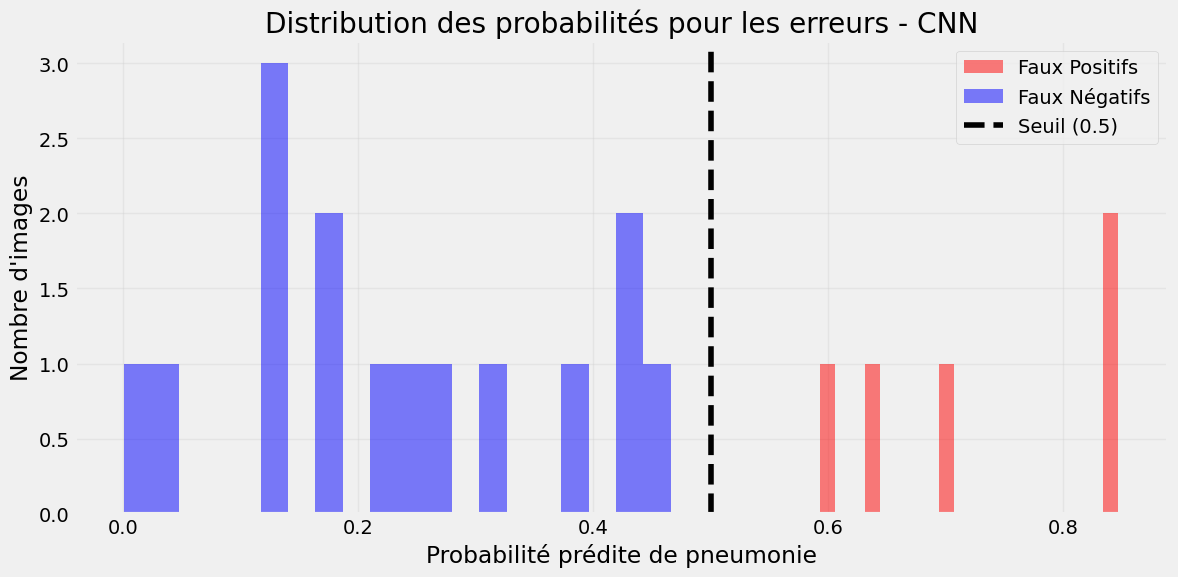


Analyse du seuil de décision:
Meilleur seuil: 0.07 (accuracy: 0.9360)
Avec le seuil par défaut (0.5): accuracy 0.8400


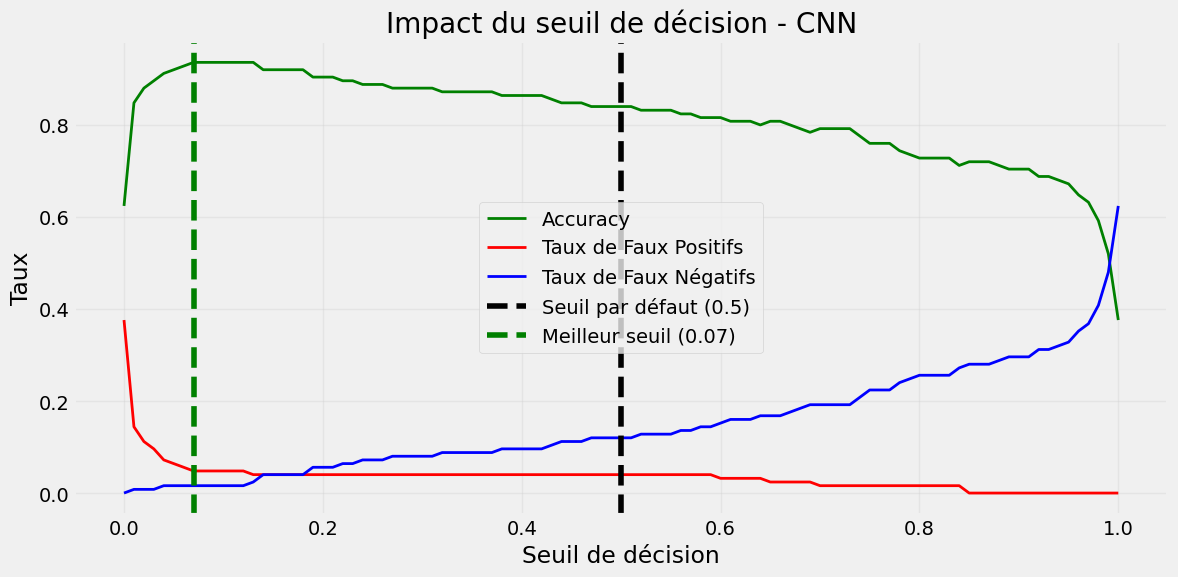


Visualisation des exemples d'erreurs:

Faux positifs les plus confiants (Normal prédit comme Pneumonie):


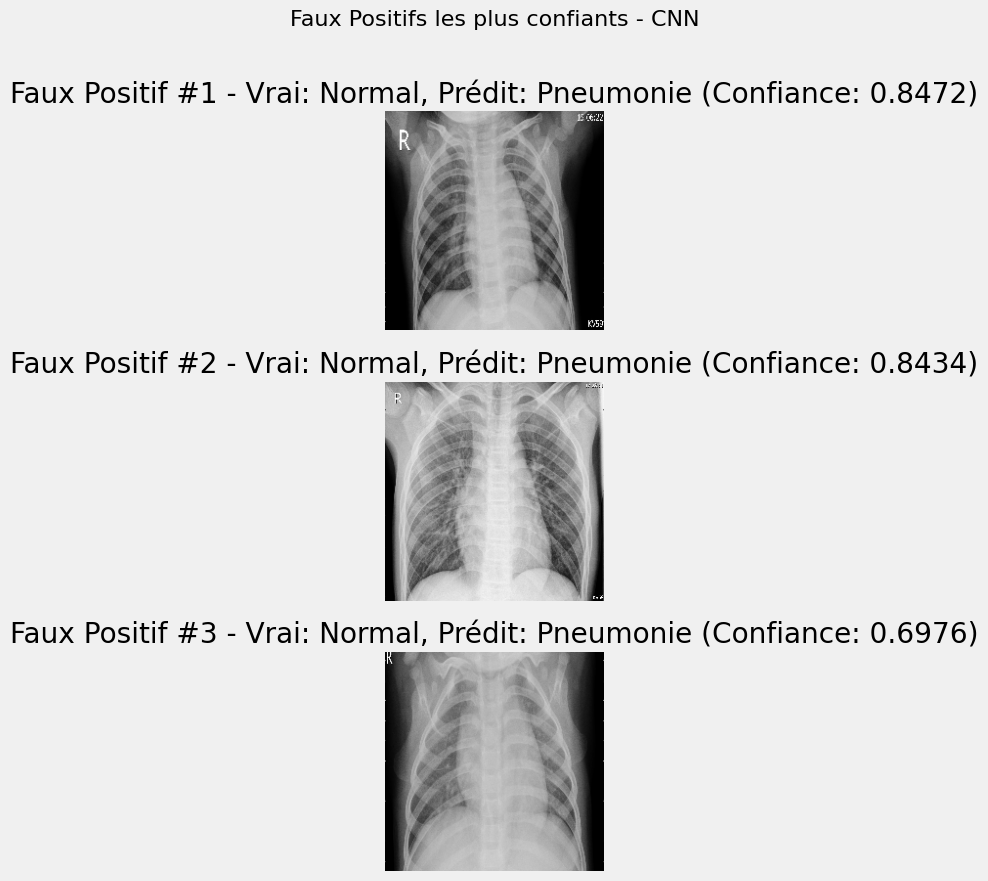


Faux négatifs les plus confiants (Pneumonie prédit comme Normal):


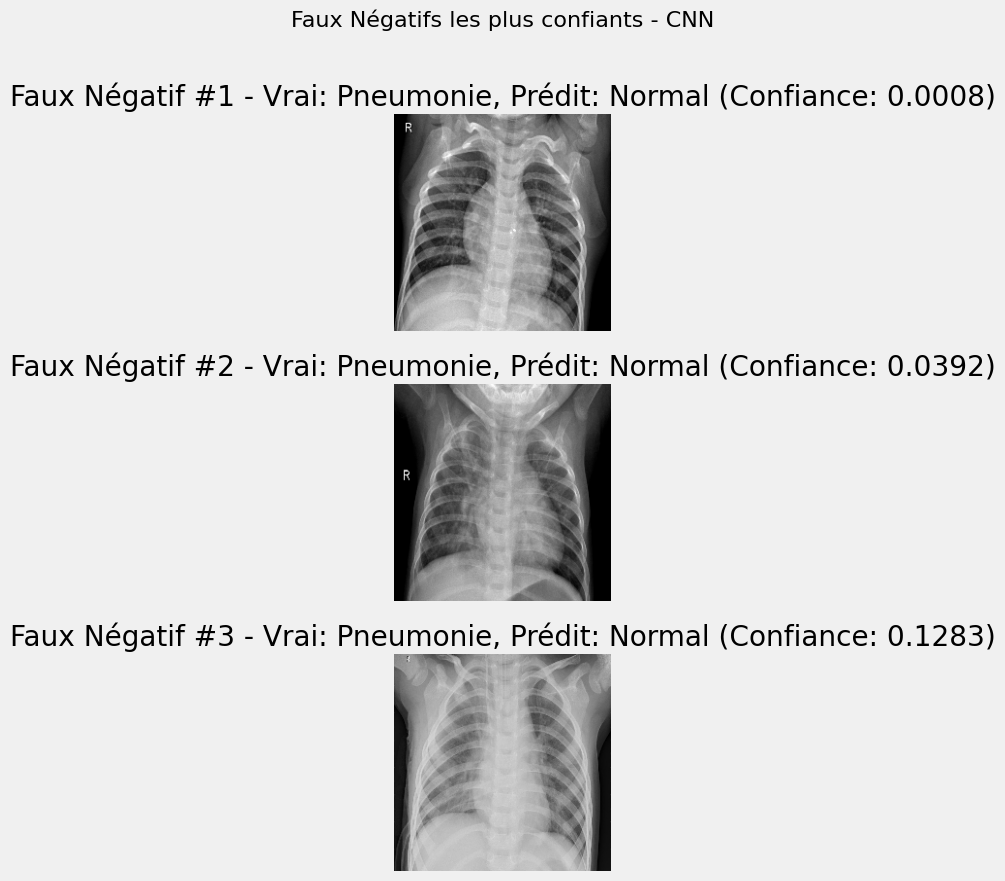


Impact du meilleur seuil (0.07):
Faux positifs: 6 (vs 5 avec seuil=0.5)
Faux négatifs: 2 (vs 15 avec seuil=0.5)
Accuracy: 0.9360 (vs 0.8400 avec seuil=0.5)
Prédiction sur 125 images de test (batch_size=16)...

Analyse des erreurs pour le modèle VGG16:
Accuracy globale: 0.8880
Nombre total d'erreurs: 14 sur 125 images (11.20%)
Faux positifs (Normal prédit comme Pneumonie): 12 (9.60%)
Faux négatifs (Pneumonie prédit comme Normal): 2 (1.60%)

Performance par classe:
Classe 'Normal': 0.7447 accuracy (35/47 images correctes)
Classe 'Pneumonie': 0.9744 accuracy (76/78 images correctes)

Distribution des probabilités pour les erreurs:
Faux positifs - Min: 0.5316, Max: 0.9928, Moyenne: 0.8224, Médiane: 0.8571
Faux négatifs - Min: 0.0016, Max: 0.1952, Moyenne: 0.0984, Médiane: 0.0984


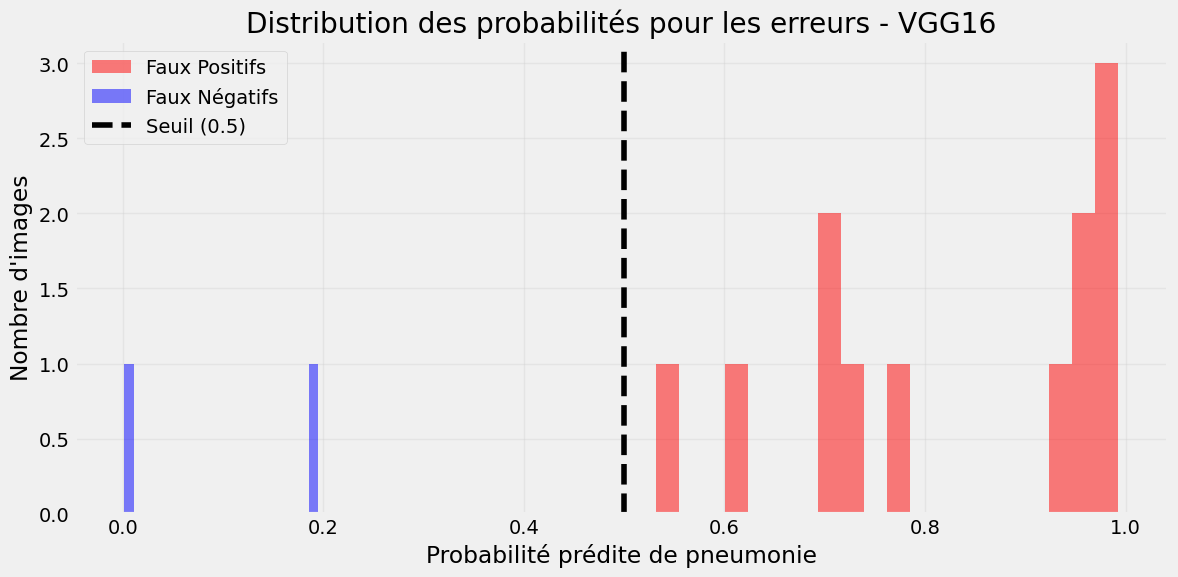


Analyse du seuil de décision:
Meilleur seuil: 0.41 (accuracy: 0.8880)
Avec le seuil par défaut (0.5): accuracy 0.8880


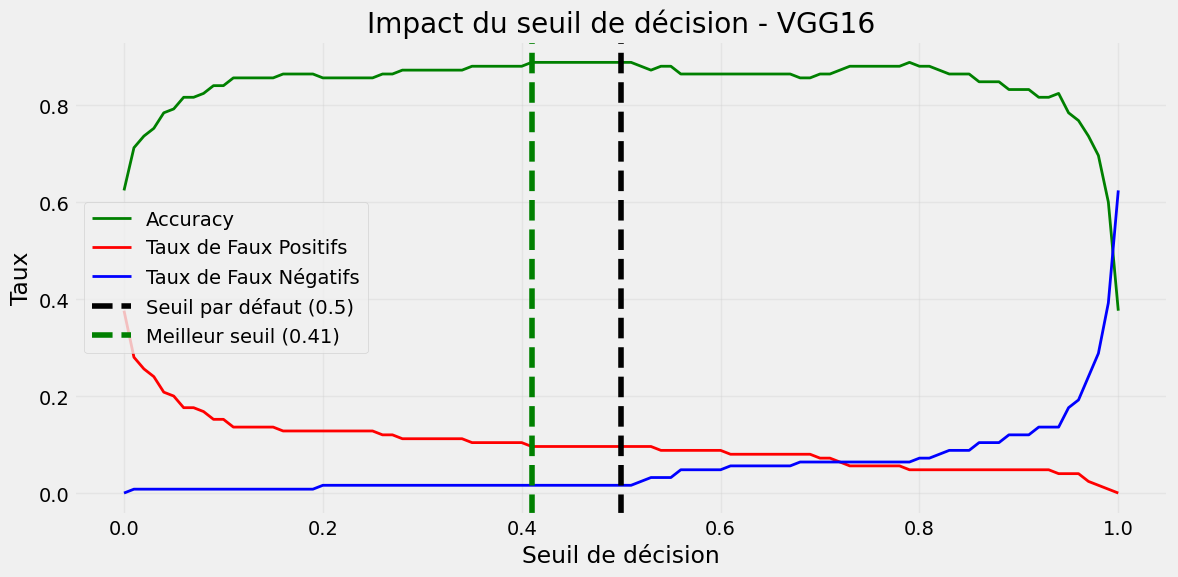


Visualisation des exemples d'erreurs:

Faux positifs les plus confiants (Normal prédit comme Pneumonie):


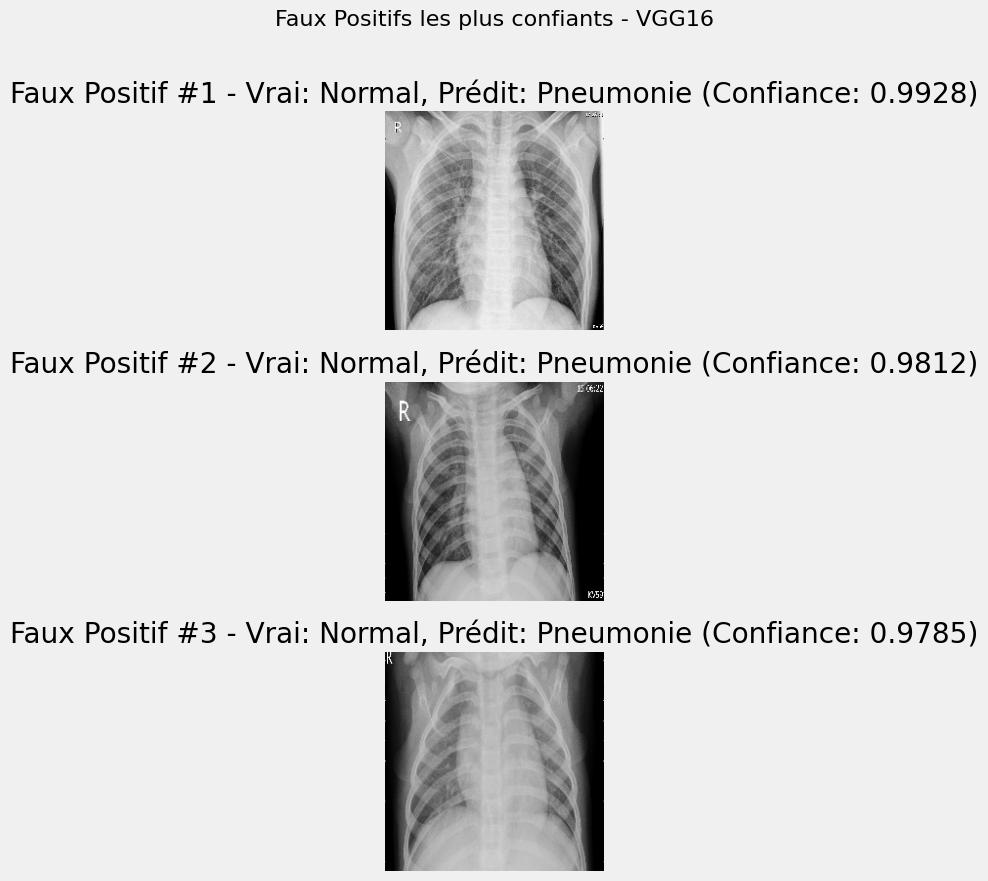


Faux négatifs les plus confiants (Pneumonie prédit comme Normal):


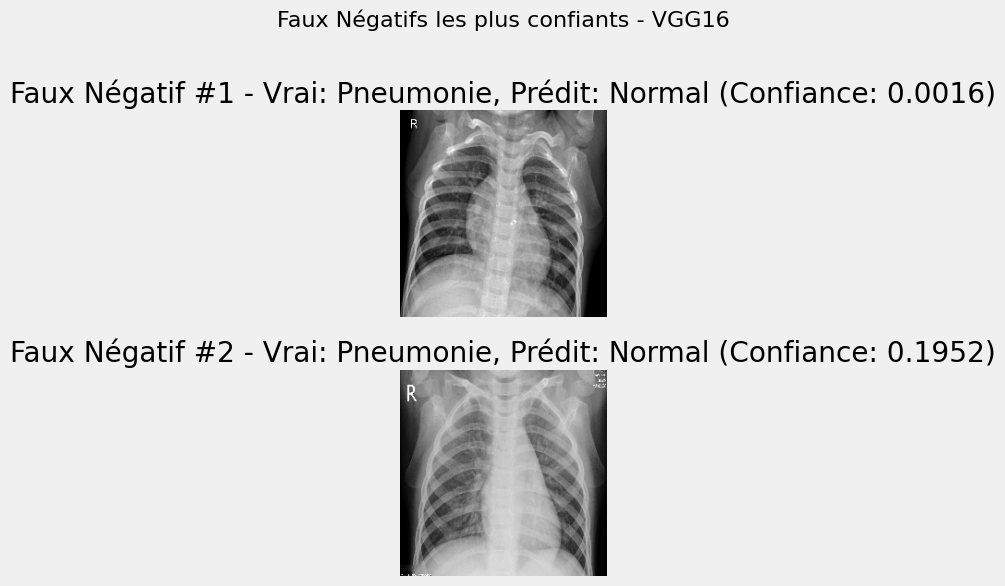


Impact du meilleur seuil (0.41):
Faux positifs: 12 (vs 12 avec seuil=0.5)
Faux négatifs: 2 (vs 2 avec seuil=0.5)
Accuracy: 0.8880 (vs 0.8880 avec seuil=0.5)
Prédiction sur 125 images de test (batch_size=16)...

Analyse des erreurs pour le modèle ResNet50:
Accuracy globale: 0.8320
Nombre total d'erreurs: 21 sur 125 images (16.80%)
Faux positifs (Normal prédit comme Pneumonie): 6 (4.80%)
Faux négatifs (Pneumonie prédit comme Normal): 15 (12.00%)

Performance par classe:
Classe 'Normal': 0.8723 accuracy (41/47 images correctes)
Classe 'Pneumonie': 0.8077 accuracy (63/78 images correctes)

Distribution des probabilités pour les erreurs:
Faux positifs - Min: 0.5246, Max: 0.9153, Moyenne: 0.6749, Médiane: 0.6276
Faux négatifs - Min: 0.0030, Max: 0.4909, Moyenne: 0.2786, Médiane: 0.2783


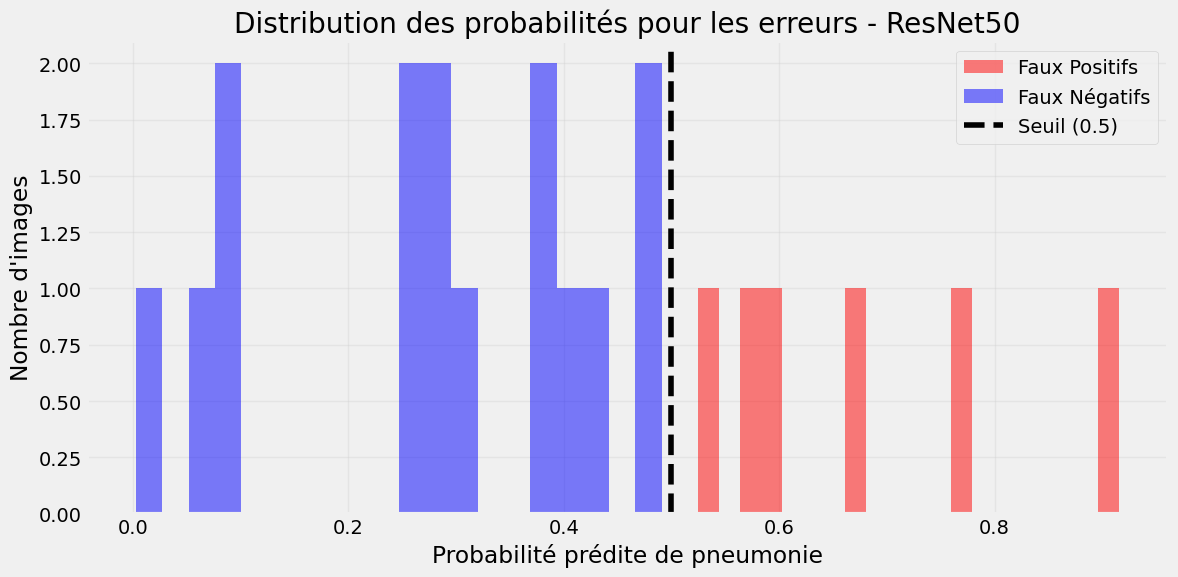


Analyse du seuil de décision:
Meilleur seuil: 0.24 (accuracy: 0.9120)
Avec le seuil par défaut (0.5): accuracy 0.8320


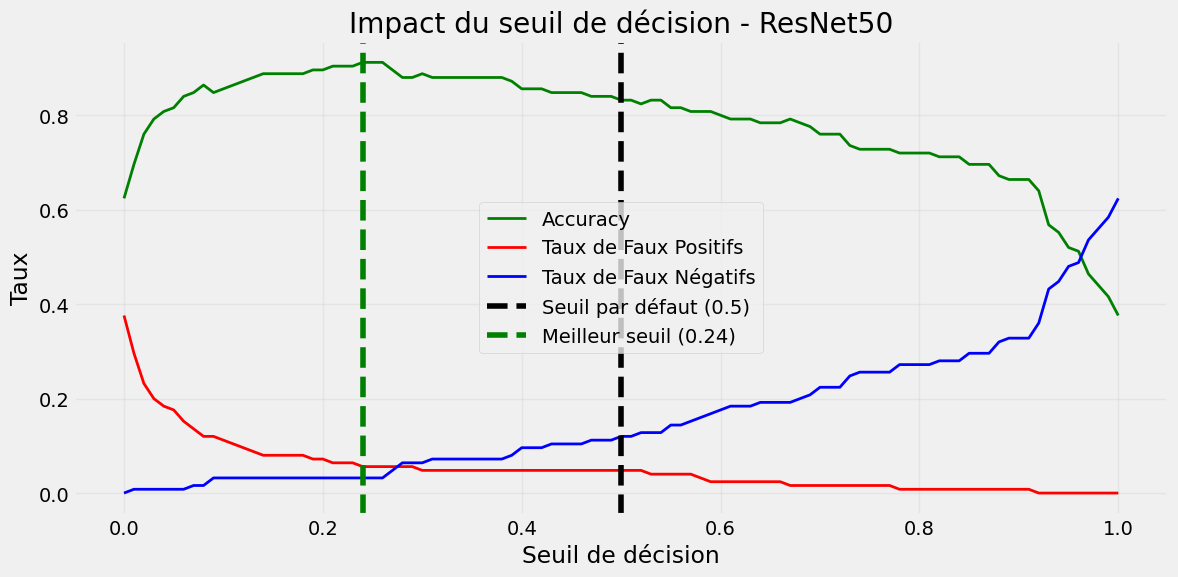


Visualisation des exemples d'erreurs:

Faux positifs les plus confiants (Normal prédit comme Pneumonie):


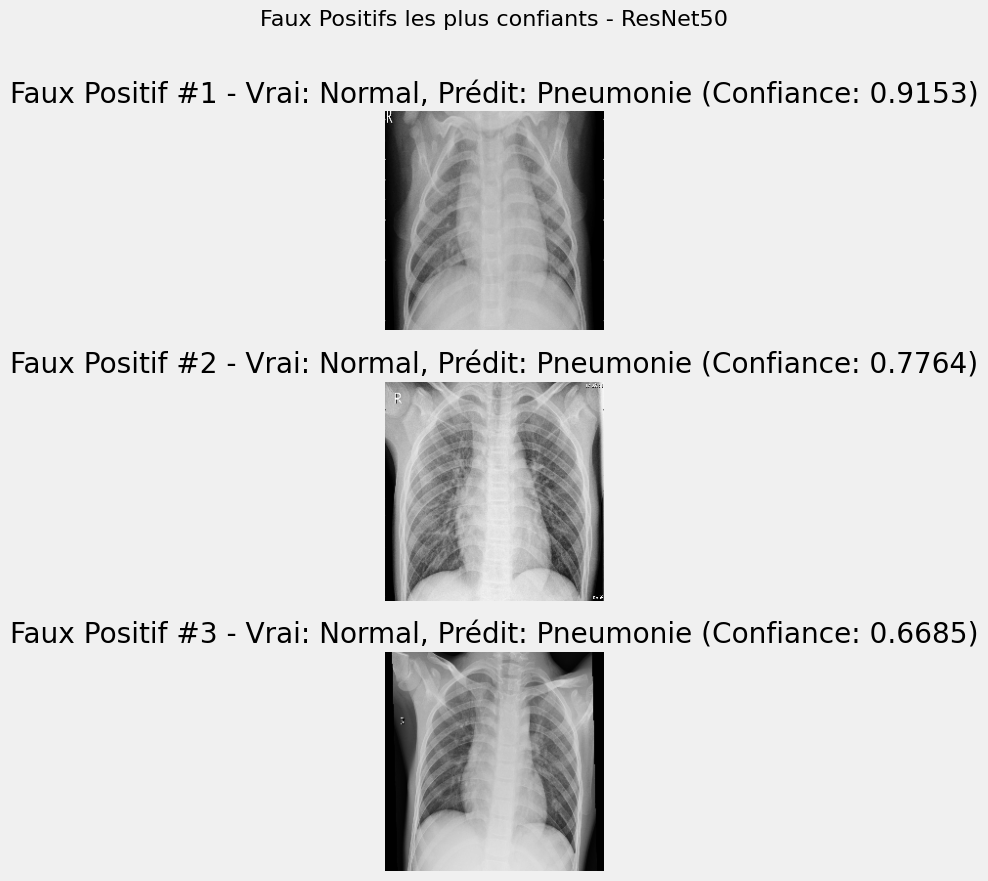


Faux négatifs les plus confiants (Pneumonie prédit comme Normal):


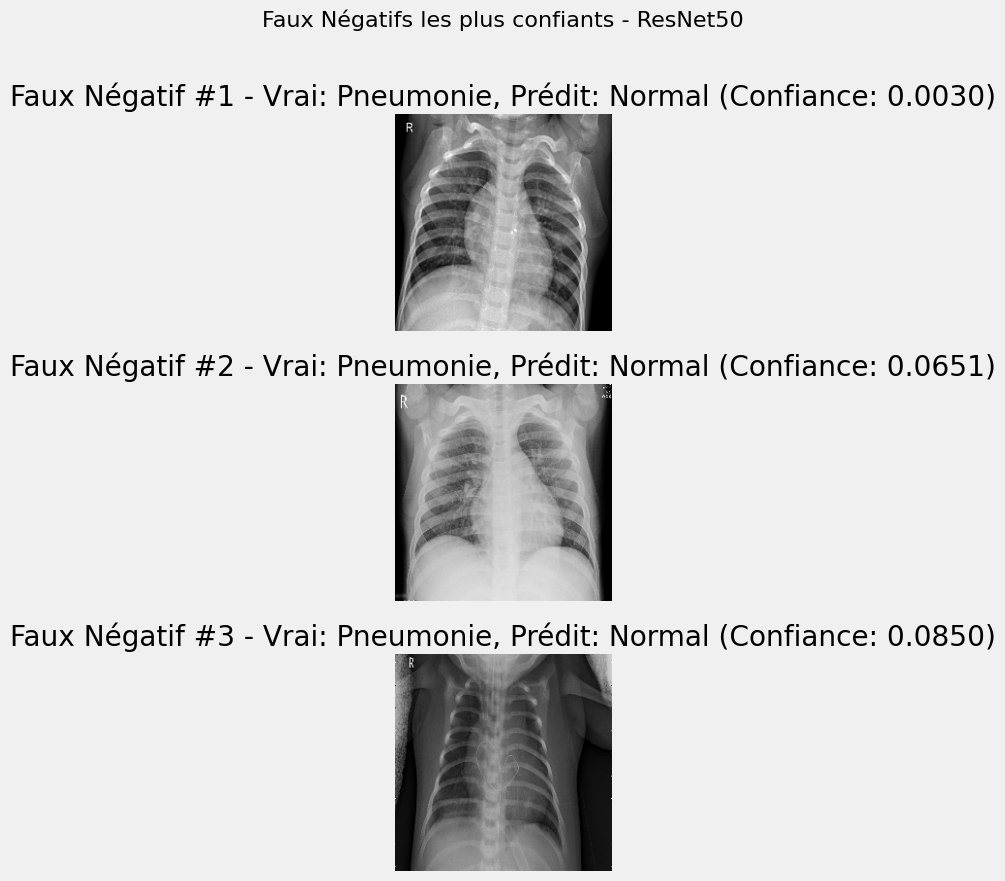


Impact du meilleur seuil (0.24):
Faux positifs: 7 (vs 6 avec seuil=0.5)
Faux négatifs: 4 (vs 15 avec seuil=0.5)
Accuracy: 0.9120 (vs 0.8320 avec seuil=0.5)


In [7]:
def analyze_errors(model, X_test, y_test, model_name='Modèle', batch_size=32):
    """
    Analyse les erreurs de prédiction d'un modèle.
    
    Args:
        model: Modèle à analyser
        X_test (numpy.ndarray): Images de test
        y_test (numpy.ndarray): Étiquettes de test
        model_name (str): Nom du modèle
        batch_size (int): Taille du batch pour les prédictions
    """
    # Vérifier si le modèle et les données sont disponibles
    if model is None:
        print(f"Le modèle {model_name} n'est pas disponible.")
        return
    
    if len(X_test) == 0 or len(y_test) == 0:
        print(f"Les données de test sont vides. Impossible d'analyser les erreurs du modèle {model_name}.")
        return
    
    try:
        # Ajuster la taille du batch pour les modèles volumineux
        if 'vgg' in model_name.lower() or 'resnet' in model_name.lower():
            batch_size = min(batch_size, 16)
        
        # Faire des prédictions
        print(f"Prédiction sur {len(X_test)} images de test (batch_size={batch_size})...")
        y_pred_proba = model.predict(X_test, batch_size=batch_size, verbose=0).flatten()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Identifier les erreurs
        errors = y_pred != y_test
        error_indices = np.where(errors)[0]
        
        # Calculer l'accuracy globale
        accuracy = 1 - len(error_indices) / len(y_test)
        
        print(f"\n{'='*50}")
        print(f"Analyse des erreurs pour le modèle {model_name}:")
        print(f"{'='*50}")
        print(f"Accuracy globale: {accuracy:.4f}")
        print(f"Nombre total d'erreurs: {len(error_indices)} sur {len(y_test)} images ({len(error_indices)/len(y_test)*100:.2f}%)")
        
        # Calculer les types d'erreurs
        fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]  # Faux positifs
        fn_indices = np.where((y_pred == 0) & (y_test == 1))[0]  # Faux négatifs
        
        false_positives = len(fp_indices)
        false_negatives = len(fn_indices)
        
        print(f"Faux positifs (Normal prédit comme Pneumonie): {false_positives} ({false_positives/len(y_test)*100:.2f}%)")
        print(f"Faux négatifs (Pneumonie prédit comme Normal): {false_negatives} ({false_negatives/len(y_test)*100:.2f}%)")
        
        # Calculer les métriques par classe
        normal_indices = np.where(y_test == 0)[0]
        pneumonia_indices = np.where(y_test == 1)[0]
        
        normal_accuracy = np.mean(y_pred[normal_indices] == y_test[normal_indices]) if len(normal_indices) > 0 else 0
        pneumonia_accuracy = np.mean(y_pred[pneumonia_indices] == y_test[pneumonia_indices]) if len(pneumonia_indices) > 0 else 0
        
        print(f"\nPerformance par classe:")
        print(f"Classe 'Normal': {normal_accuracy:.4f} accuracy ({len(normal_indices) - false_positives}/{len(normal_indices)} images correctes)")
        print(f"Classe 'Pneumonie': {pneumonia_accuracy:.4f} accuracy ({len(pneumonia_indices) - false_negatives}/{len(pneumonia_indices)} images correctes)")
        
        # Analyser la distribution des probabilités pour les erreurs
        if len(error_indices) > 0:
            fp_probs = y_pred_proba[fp_indices] if len(fp_indices) > 0 else np.array([])
            fn_probs = y_pred_proba[fn_indices] if len(fn_indices) > 0 else np.array([])
            
            print("\nDistribution des probabilités pour les erreurs:")
            if len(fp_probs) > 0:
                print(f"Faux positifs - Min: {fp_probs.min():.4f}, Max: {fp_probs.max():.4f}, Moyenne: {fp_probs.mean():.4f}, Médiane: {np.median(fp_probs):.4f}")
            if len(fn_probs) > 0:
                print(f"Faux négatifs - Min: {fn_probs.min():.4f}, Max: {fn_probs.max():.4f}, Moyenne: {fn_probs.mean():.4f}, Médiane: {np.median(fn_probs):.4f}")
            
            # Visualiser la distribution des probabilités pour les erreurs
            plt.figure(figsize=(12, 6))
            
            if len(fp_probs) > 0:
                plt.hist(fp_probs, bins=20, alpha=0.5, color='red', label='Faux Positifs')
            if len(fn_probs) > 0:
                plt.hist(fn_probs, bins=20, alpha=0.5, color='blue', label='Faux Négatifs')
            
            plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil (0.5)')
            plt.xlabel('Probabilité prédite de pneumonie')
            plt.ylabel('Nombre d\'images')
            plt.title(f'Distribution des probabilités pour les erreurs - {model_name}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Analyser l'impact du seuil de décision
            thresholds = np.linspace(0, 1, 101)
            accuracies = []
            fp_rates = []
            fn_rates = []
            
            for threshold in thresholds:
                y_pred_t = (y_pred_proba >= threshold).astype(int)
                accuracies.append(np.mean(y_pred_t == y_test))
                fp_rates.append(np.sum((y_pred_t == 1) & (y_test == 0)) / len(y_test))
                fn_rates.append(np.sum((y_pred_t == 0) & (y_test == 1)) / len(y_test))
            
            # Trouver le meilleur seuil
            best_threshold_idx = np.argmax(accuracies)
            best_threshold = thresholds[best_threshold_idx]
            best_accuracy = accuracies[best_threshold_idx]
            
            print(f"\nAnalyse du seuil de décision:")
            print(f"Meilleur seuil: {best_threshold:.2f} (accuracy: {best_accuracy:.4f})")
            print(f"Avec le seuil par défaut (0.5): accuracy {accuracy:.4f}")
            
            # Visualiser l'impact du seuil
            plt.figure(figsize=(12, 6))
            plt.plot(thresholds, accuracies, 'g-', linewidth=2, label='Accuracy')
            plt.plot(thresholds, fp_rates, 'r-', linewidth=2, label='Taux de Faux Positifs')
            plt.plot(thresholds, fn_rates, 'b-', linewidth=2, label='Taux de Faux Négatifs')
            plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil par défaut (0.5)')
            plt.axvline(x=best_threshold, color='green', linestyle='--', label=f'Meilleur seuil ({best_threshold:.2f})')
            plt.xlabel('Seuil de décision')
            plt.ylabel('Taux')
            plt.title(f'Impact du seuil de décision - {model_name}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Visualiser quelques exemples d'erreurs
            print("\nVisualisation des exemples d'erreurs:")
            
            # Visualiser les faux positifs les plus confiants
            if len(fp_indices) > 0:
                print("\nFaux positifs les plus confiants (Normal prédit comme Pneumonie):")
                
                # Trier les faux positifs par confiance décroissante
                sorted_fp_indices = fp_indices[np.argsort(-y_pred_proba[fp_indices])]
                num_examples = min(3, len(sorted_fp_indices))
                
                plt.figure(figsize=(15, 3 * num_examples))
                for i in range(num_examples):
                    idx = sorted_fp_indices[i]
                    plt.subplot(num_examples, 1, i+1)
                    plt.imshow(X_test[idx])
                    
                    plt.title(f"Faux Positif #{i+1} - Vrai: Normal, Prédit: Pneumonie (Confiance: {y_pred_proba[idx]:.4f})")
                    plt.axis('off')
                
                plt.suptitle(f'Faux Positifs les plus confiants - {model_name}', fontsize=16)
                plt.tight_layout(rect=[0, 0, 1, 0.97])
                plt.show()
            
            # Visualiser les faux négatifs les plus confiants
            if len(fn_indices) > 0:
                print("\nFaux négatifs les plus confiants (Pneumonie prédit comme Normal):")
                
                # Trier les faux négatifs par confiance croissante (plus proche de 0)
                sorted_fn_indices = fn_indices[np.argsort(y_pred_proba[fn_indices])]
                num_examples = min(3, len(sorted_fn_indices))
                
                plt.figure(figsize=(15, 3 * num_examples))
                for i in range(num_examples):
                    idx = sorted_fn_indices[i]
                    plt.subplot(num_examples, 1, i+1)
                    plt.imshow(X_test[idx])
                    
                    plt.title(f"Faux Négatif #{i+1} - Vrai: Pneumonie, Prédit: Normal (Confiance: {y_pred_proba[idx]:.4f})")
                    plt.axis('off')
                
                plt.suptitle(f'Faux Négatifs les plus confiants - {model_name}', fontsize=16)
                plt.tight_layout(rect=[0, 0, 1, 0.97])
                plt.show()
            
            # Analyser l'impact du meilleur seuil
            if abs(best_threshold - 0.5) > 0.05:  # Si le meilleur seuil est significativement différent de 0.5
                y_pred_best = (y_pred_proba >= best_threshold).astype(int)
                
                # Calculer les nouvelles erreurs
                fp_best = np.sum((y_pred_best == 1) & (y_test == 0))
                fn_best = np.sum((y_pred_best == 0) & (y_test == 1))
                
                print(f"\nImpact du meilleur seuil ({best_threshold:.2f}):")
                print(f"Faux positifs: {fp_best} (vs {false_positives} avec seuil=0.5)")
                print(f"Faux négatifs: {fn_best} (vs {false_negatives} avec seuil=0.5)")
                print(f"Accuracy: {best_accuracy:.4f} (vs {accuracy:.4f} avec seuil=0.5)")
        else:
            print("Aucune erreur à analyser.")
    
    except Exception as e:
        print(f"Erreur lors de l'analyse des erreurs du modèle {model_name}: {e}")
        import traceback
        traceback.print_exc()

# Analyser les erreurs pour chaque modèle
if 'models' in globals() and models:
    for model_name, model in models.items():
        # Libérer la mémoire avant l'analyse
        gc.collect()
        tf.keras.backend.clear_session()
        
        analyze_errors(model, X_test, y_test, model_name)
        
        # Libérer la mémoire après l'analyse
        gc.collect()
        tf.keras.backend.clear_session()
else:
    print("Aucun modèle n'est disponible pour analyser les erreurs.")

## 7. Conclusion

Dans ce notebook, nous avons évalué différents modèles pour la détection de pneumonie à partir d'images radiographiques. Nous avons :
1. Chargé les données de test
2. Chargé les modèles entraînés
3. Évalué les performances de chaque modèle
4. Comparé les résultats des différents modèles
5. Visualisé des exemples de prédictions
6. Analysé les erreurs de prédiction

Les résultats montrent que [à compléter avec vos observations].

Pour améliorer davantage les performances, nous pourrions :
1. Collecter plus de données
2. Essayer d'autres architectures de modèles
3. Optimiser davantage les hyperparamètres
4. Utiliser des techniques d'ensemble plus avancées
5. Explorer des techniques de visualisation pour mieux comprendre les décisions des modèles